In [1]:
import os
import pandas as pd
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import numpy as np
import pickle
import pprint # Pretty Printer!
import warnings

c:\Users\ilebe\anaconda3\envs\stan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
obs_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/All Processed Final Location"
covariates_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/covariates"
stan_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model"
get_rid_of_these_sites_retn_too_large = ["H23-RS-167", "H-RS-1-98", "H23-RS-109"]
figures_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\figures"

In [3]:
trial1_output_location_for_TEWA = r"C:\Users\ilebe\Documents\!Masters!\Analysis\2. Output\Aundance conditional on Occupancy\TEWA\Trial1"

In [4]:
counts = pd.read_csv(os.path.join(obs_path, "count_per_site_filtered.csv"))
veg = pd.read_csv(os.path.join(covariates_path, 'AVI_merged_4cats.csv'), usecols=['location', 'percent_decid'	,'percent_mixed',	'percent_spruce'	,'percent_pine'
])
patch_size_lat_long = pd.read_csv(os.path.join(covariates_path, "RETN_all_years_top_up_area_and_perimeter.csv"))
date_time = pd.read_csv(os.path.join(covariates_path, "Julian_day_TimeofDay.csv"))
harv_age = pd.read_csv(os.path.join(covariates_path, "Harv_age.csv"))

In [5]:
patch_size_lat_long.head()


location   latitude   longitude   RETN_m2  RETN_perimeter_m
0  H-RS-1-100  52.624480 -115.184130  13017.97            482.68
1   H-RS-5-60  51.558410 -115.184743  12902.49            789.82
2  H-RS-1-105  52.604922 -115.142002  10848.07            417.47
3  H22-RS-274  58.561479 -118.405779  10524.53            577.94
4   H-RS-1-66  53.490616 -116.480982  10319.53            383.33

In [6]:
number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
number_of_visits_per_site.head(3)

location  number_of_visits
0  H-CC-2-13                 3
1  H22-RS-84                 7
2  H-RS-6-53                 8

In [7]:
list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()
# list_of_sites_to_use.remove("H23-RS-167")
# list_of_sites_to_use.remove("H-RS-1-98")
# list_of_sites_to_use.remove("H23-RS-109")

In [8]:
len(list_of_sites_to_use)

395

In [9]:
counts_10vis = counts[counts['location'].isin(list_of_sites_to_use)]
veg_10vis = veg[veg['location'].isin(list_of_sites_to_use)]
patch_size_lat_long_10vis = patch_size_lat_long[patch_size_lat_long['location'].isin(list_of_sites_to_use)]
date_time_10vis = date_time[date_time['location'].isin(list_of_sites_to_use)]
harv_age_10vis = harv_age[harv_age['location'].isin(list_of_sites_to_use)]

In [10]:
len(harv_age_10vis.location.unique())

395

In [11]:
# Reading the obs_count_10.csv file
obs_count_10 = counts_10vis

# Filter out sites with less than 10 visits
sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]

# Subsample to exactly 10 visits per site
final_obs_count = filtered_obs_count.groupby('location').apply(lambda x: x.sample(n=10, replace=False)).reset_index(drop=True)
final_obs_count['visit_number'] = final_obs_count.groupby('location').cumcount() + 1


In [12]:
final_obs_count['recording_date_time'] = pd.to_datetime(final_obs_count['recording_date_time'])

final_obs_count['Day_of_Year'] = final_obs_count['recording_date_time'].dt.dayofyear

final_obs_count['Time_of_Day'] = final_obs_count['recording_date_time'].dt.hour * 60 + final_obs_count['recording_date_time'].dt.minute

In [13]:
veg_10vis.head(4)

location  percent_decid  percent_mixed  percent_spruce  percent_pine
0   AM-429-NW       0.039080       0.212197             0.0      0.748722
1     BG-6-94       0.985555       0.000000             0.0      0.014445
2  FMX-2-18-2       0.092450       0.907550             0.0      0.000000
3    H22-CC-0       1.000000       0.000000             0.0      0.000000

In [14]:
# Extracting the covariates
# counts
# Pivot the dataframe based on the new visit_number
N_matrix_visit_num = final_obs_count.pivot(index='location', columns='visit_number', values='TEWA').fillna(0).astype(int).values.tolist()

percent_deciduous = veg_10vis['percent_decid'].tolist()
percent_mixedwood = veg_10vis['percent_mixed'].tolist()
percent_pine = veg_10vis['percent_pine'].tolist()
percent_spruce = veg_10vis['percent_spruce'].tolist()
# Extracting the covariates
latitude = patch_size_lat_long_10vis['latitude'].tolist()
longitude = patch_size_lat_long_10vis['longitude'].tolist()
size = patch_size_lat_long_10vis['RETN_m2'].tolist()

age = harv_age_10vis['Year_since_logging'].tolist()

date_time_10vis_sorted = date_time_10vis.sort_values(by=['location', 'recording_date_time'])

time_of_day_matrix = final_obs_count.pivot(index='location', columns='visit_number', values='Time_of_Day').fillna(0).astype(int).values.tolist()
Julian_date_matrix = final_obs_count.pivot(index='location', columns='visit_number', values='Day_of_Year').fillna(0).astype(int).values.tolist()

In [15]:
size_log = [math.log(i, 10) if i != 0 else i for i in size]
spruce_log = [math.sqrt(i) if i != 0 else i for i in percent_spruce]
spruce_with_added_constant = [i+1 for i in percent_spruce]

In [16]:
spruce_boxcox = stats.boxcox([i+1 for i in percent_spruce])[0]

## Prior predictive checks

Generate simulated data form the model using prior distributions and comparing these generated values to the observed data. This helps whether the model and priors are appropriate for the data and context.

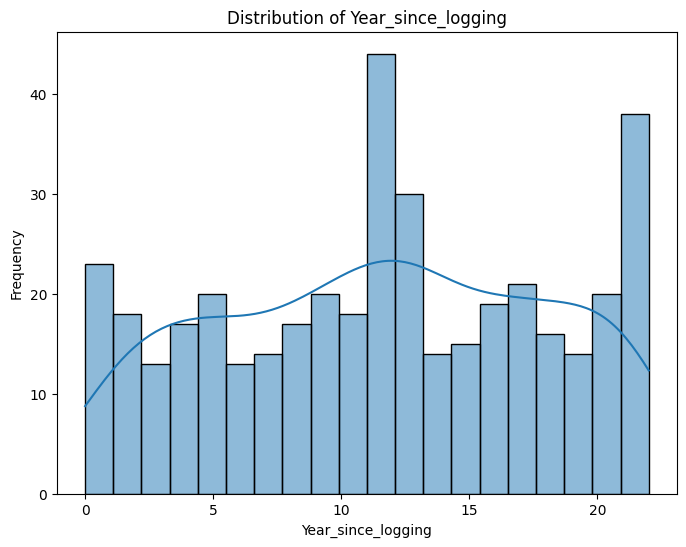

In [20]:
# Plot the distribution of Year_since_logging
plt.figure(figsize=(8, 6))
sns.histplot(harv_age['Year_since_logging'], kde=True, bins=20)
plt.title('Distribution of Year_since_logging')
plt.xlabel('Year_since_logging')
plt.ylabel('Frequency')
plt.show()

# Are the bird counts a Poisson?

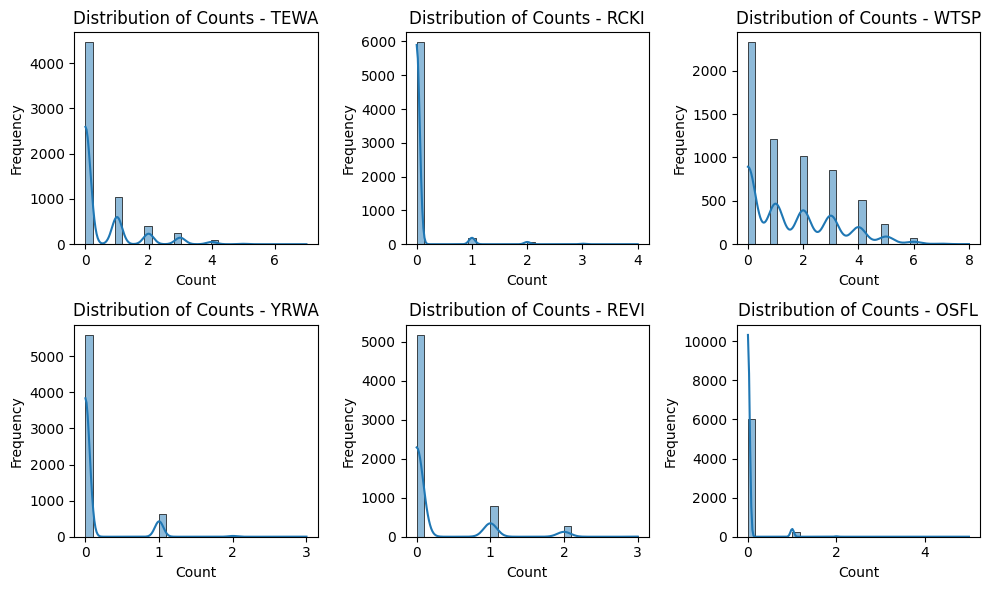

In [23]:
# Plot the distribution of counts for each bird species in subplots
plt.figure(figsize=(10, 6))

# List of bird species
bird_species = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.histplot(counts[species], kde=True, bins=30)
    plt.title(f'Distribution of Counts - {species}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## This seems fairly zero-inflated!

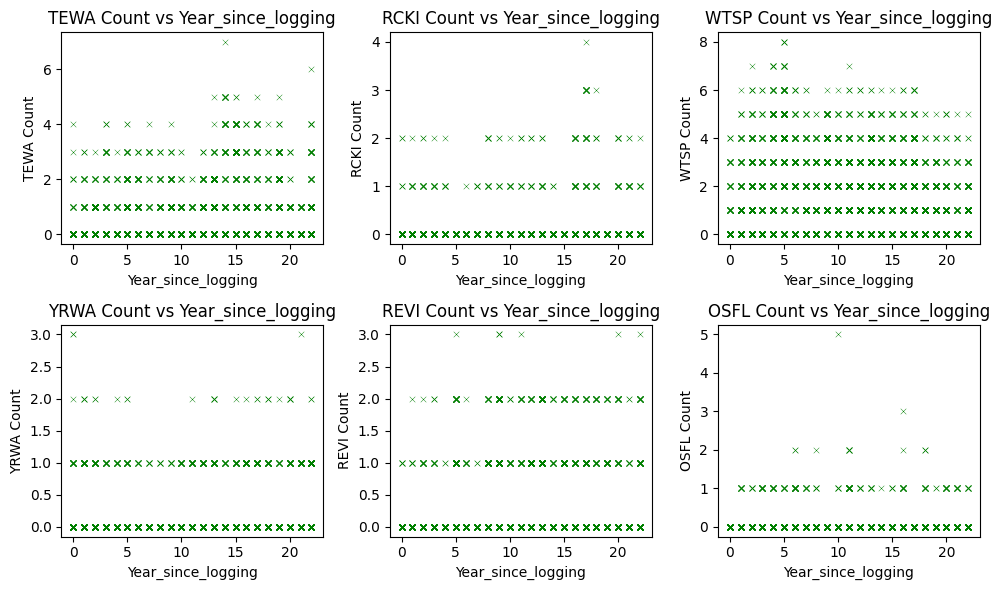

In [30]:
# Merge the two datasets on the 'location' column
merged_data = pd.merge(counts, harv_age, on='location')
# Plotting the total bird count against Year_since_logging for each species in subplots
plt.figure(figsize=(10, 6))

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=merged_data, x='Year_since_logging', y=species,  marker='x', color='green', s=16)
    plt.title(f'{species} Count vs Year_since_logging')
    plt.xlabel('Year_since_logging')
    plt.ylabel(f'{species} Count')

plt.tight_layout()
plt.show()



## First, let's simulate some counts from a Poisson process with lambdas generated from a Uniform distribution

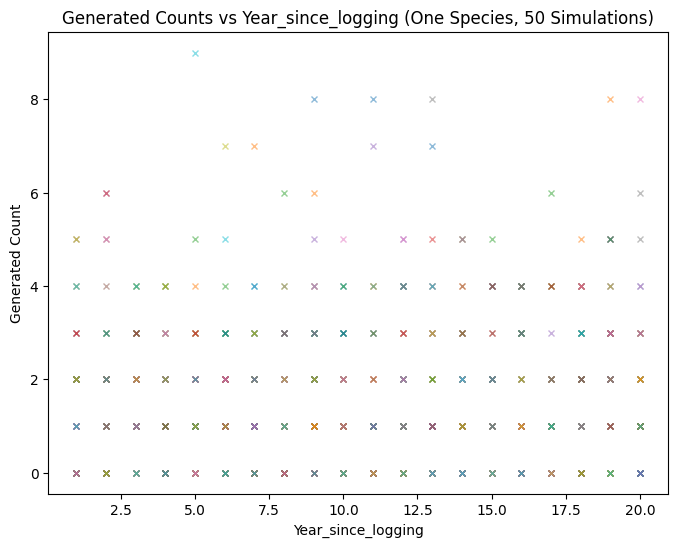

In [87]:
# Define unique years for simulation
unique_years = np.arange(1, 21)  # Adjust as per your data

# Number of simulations
n_simulations = 50

# Plotting the generated data for one species
plt.figure(figsize=(8, 6))

for i in range(n_simulations):
    # Simulating Poisson rates (lambdas) for one species from a uniform distribution between 0 and 8
    lambdas_simulated_one_species = np.random.uniform(low=0, high=3, size=len(unique_years))
    
    # Generating data by sampling from a Poisson distribution with the simulated lambdas
    generated_counts_one_species = np.random.poisson(lambdas_simulated_one_species)
    
    # Plotting the generated data for each simulation
    plt.plot(unique_years, generated_counts_one_species, marker='x', linestyle='', markersize=5, alpha=0.5)

plt.title('Generated Counts vs Year_since_logging (One Species, 50 Simulations)')
plt.xlabel('Year_since_logging')
plt.ylabel('Generated Count')
plt.show()


That looks pretty good. The sd on the lambdas ~ U(mean, sd) could change between species.<br>

Now, let's think about generating lambdas from slopes and intercepts.<br>
When using a log-link in a Poisson, the relationship between the predictors and the response variable is expressed on the log scale. The mean of the Poisson distribution ($\lambda$) is related to the predictoirs through:<br>
> log(lambda) = intercept + beta * covariate

1. Simulate intercepts and slopes. Lambda and intercept must be positive.
- simulate alpha from a log-normal
- simulate beta form a normal

2. Calculate lambda
- using the log-linear expression, doing some matrix algebra

3. Exponentiate lambda, so that it is always positive

4. Plots!




**Abundance integrated occupancy**

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30728\3461955722.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


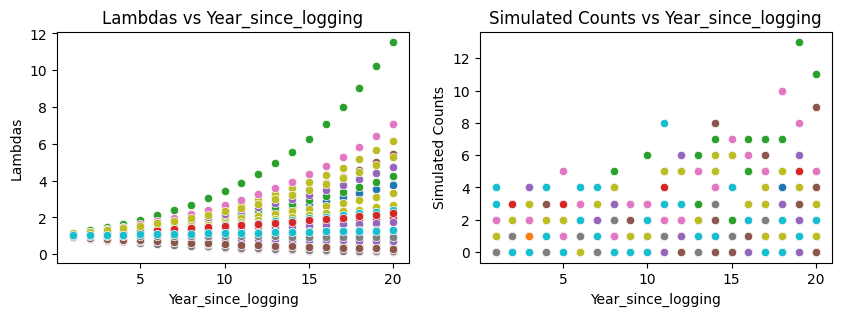

In [152]:
# Define unique years for simulation
unique_years = np.arange(1, 21)  # Adjust as per your data

# Number of simulations
n_simulations = 50

# Simulating intercepts (alpha) from a log-normal distribution
# alphas_simulated = np.random.lognormal(mean=0.04, sigma=0.001, size=n_simulations)

# can only be positve
alphas_simulated = np.random.exponential(scale=0.03, size=n_simulations)

# Simulating slopes (beta) from a normal distribution
betas_simulated = np.random.normal(loc=0, scale=0.05, size=n_simulations)

# Maximum allowable lambda value
max_lambda = 5  # Adjust this value based on your specific requirements

# Assume alphas_simulated and betas_simulated are column matrices and unique_years is a row array

# Reshape alphas_simulated and betas_simulated to column matrices
alphas_matrix = np.array(alphas_simulated).reshape(-1, 1)
betas_matrix = np.array(betas_simulated).reshape(-1, 1)

# Calculate lambda_matrix
lambda_matrix = np.exp(alphas_matrix + betas_matrix * unique_years)

# print(lambda_matrix)

fig, ax = plt.subplots(1, 2, figsize=(10,3))
# Plotting the simulated lambdas for each simulation

for i in range(n_simulations):
    sns.scatterplot(x=unique_years, y=lambda_matrix[i], ax= ax[0])

ax[0].set_title('Lambdas vs Year_since_logging')
ax[0].set_xlabel('Year_since_logging')
ax[0].set_ylabel('Lambdas')


# Store simulated counts
simulated_counts = {}

# Generating data by sampling from a Poisson distribution with the simulated lambdas
for i in range(n_simulations):
    counts = np.random.poisson(lambda_matrix[i])  
    simulated_counts[i] = counts
 

# Plotting the simulated counts for each simulation
for i in range(n_simulations):
    sns.scatterplot(x=unique_years, y=simulated_counts[i], ax=ax[1])

ax[1].set_title('Simulated Counts vs Year_since_logging')
ax[1].set_xlabel('Year_since_logging')
ax[1].set_ylabel('Simulated Counts')
fig.show()

## These priors seem to make sense for species that have high counts, like the WTSP. They are too optimistic for some species where there are rarely more than 1 individual detected, like the YRWA.
> intercept ~ exp(0.03) <br>
> slope ~ normal(0, 0.5)

In [164]:
poisson_model = CmdStanModel(stan_file=os.path.join(stan_path, "poisson.stan"))

17:14:41 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\poisson.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\poisson.exe
17:15:08 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\poisson.exe
17:15:08 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
17:15:08 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/poisson.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/poisson.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/poisson.stan', line 30, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Ins

In [165]:
poissonModel_samples = poisson_model.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

17:15:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


17:15:11 - cmdstanpy - INFO - CmdStan done processing.


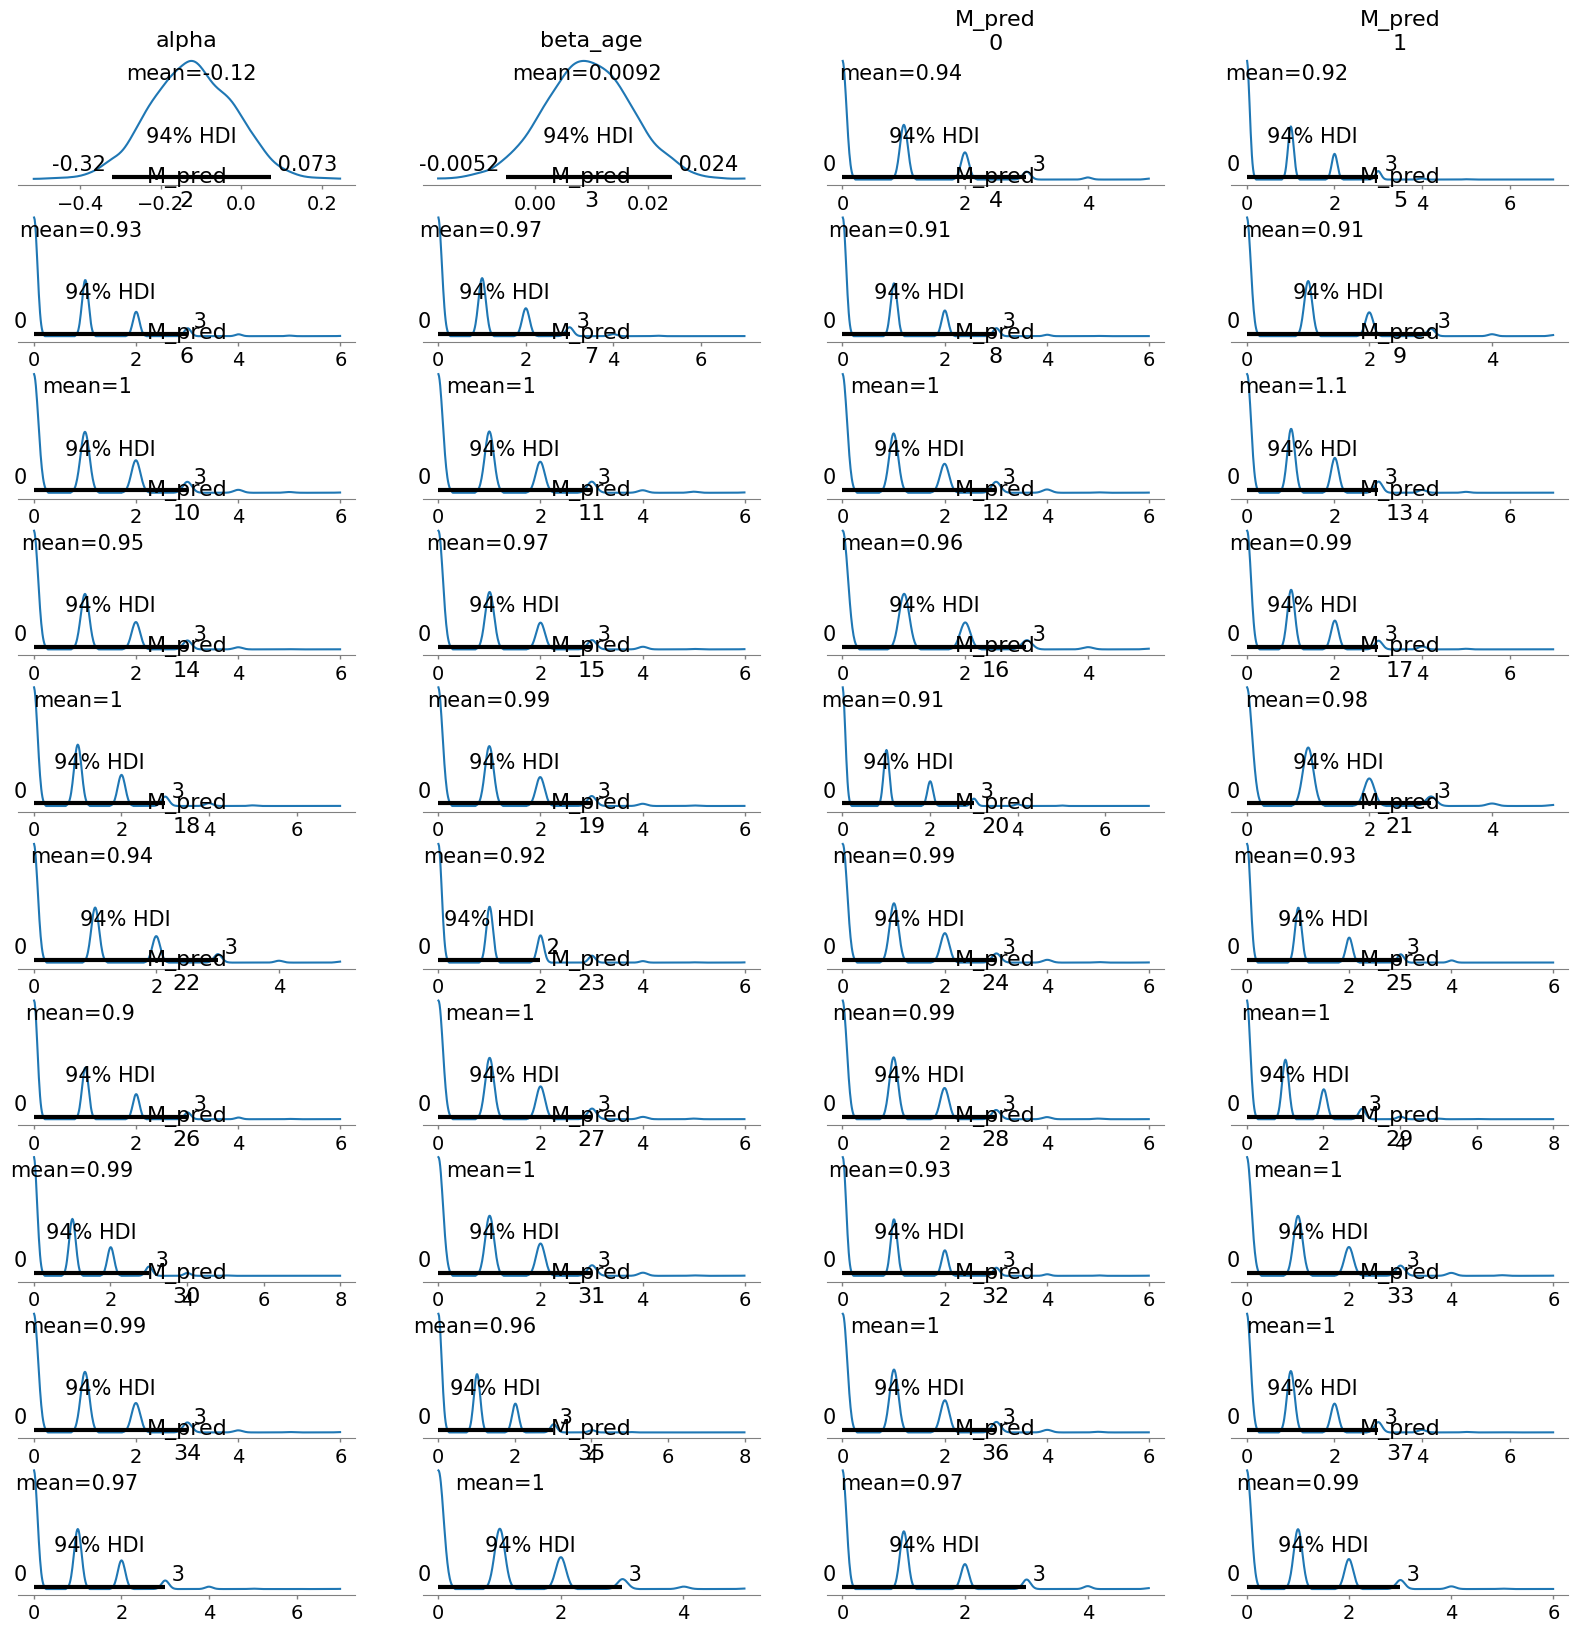

In [168]:
axes =  az.plot_posterior(poissonModel_samples, figsize=(20, 20))

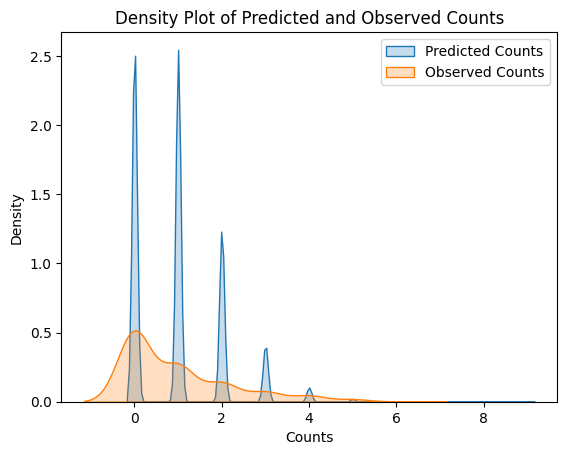

In [170]:
predicted_counts = poissonModel_samples.stan_variable('M_pred')
# Assuming obs_and_covs_dict contains 'M' as observed counts
observed_counts = obs_and_covs_dict['M']

# Plotting kernel density estimates of predicted and observed counts
sns.kdeplot(predicted_counts.flatten(), fill=True, label='Predicted Counts')
sns.kdeplot(observed_counts, fill=True, label='Observed Counts')
plt.title('Density Plot of Predicted and Observed Counts')
plt.xlabel('Counts')
plt.legend()
plt.show()


## Visualising the Bernoulli distribution of the data and testing priors

In [ ]:
# Merge the two datasets on the 'location' column
merged_data = pd.merge(counts, harv_age, on='location')
merged_age_size = pd.merge(merged_data, patch_size_lat_long, on='location')

occurrence_age_size = merged_age_size.copy(deep=True)
bird_species_columns = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Calculating the occurrence for each bird species and adding new columns to the DataFrame
for col in bird_species_columns:
    new_col = col + '_occurrence'
    merged_age_size[new_col] = (merged_age_size[col] > 0).astype(int)

occurrence_age_size[bird_species_columns] = merged_age_size[bird_species_columns].applymap(lambda x: 1 if x > 0 else 0)

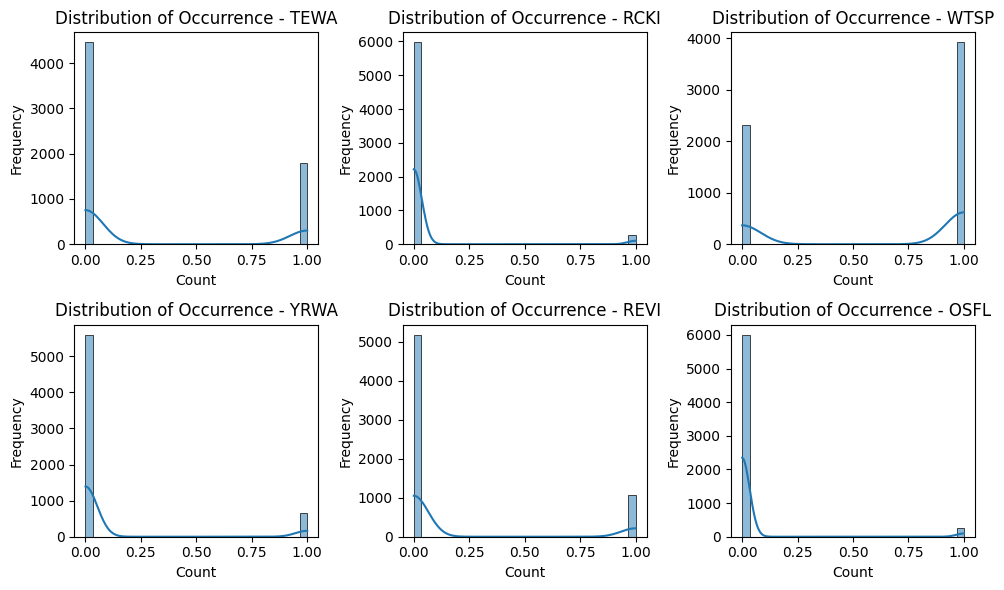

In [192]:
# Plot the distribution of counts for each bird species in subplots
plt.figure(figsize=(10, 6))

# List of bird species
bird_species = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.histplot(occurrence_age_size[species], kde=True, bins=30)
    plt.title(f'Distribution of Occurrence - {species}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

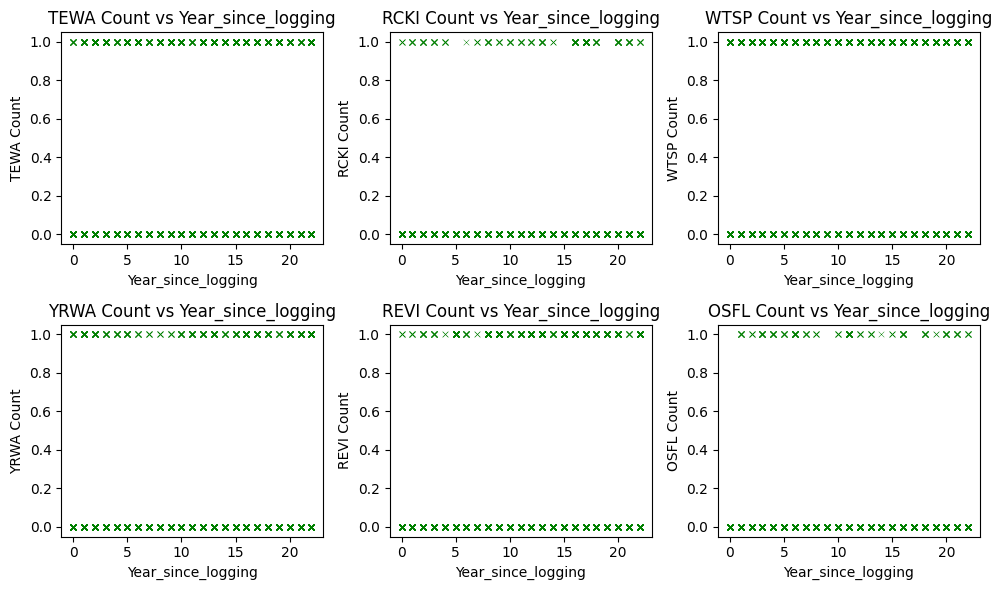

In [193]:

# Plotting the total bird count against Year_since_logging for each species in subplots
plt.figure(figsize=(10, 6))

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=occurrence_age_size, x='Year_since_logging', y=species,  marker='x', color='green', s=16)
    plt.title(f'{species} Count vs Year_since_logging')
    plt.xlabel('Year_since_logging')
    plt.ylabel(f'{species} Count')

plt.tight_layout()
plt.show()


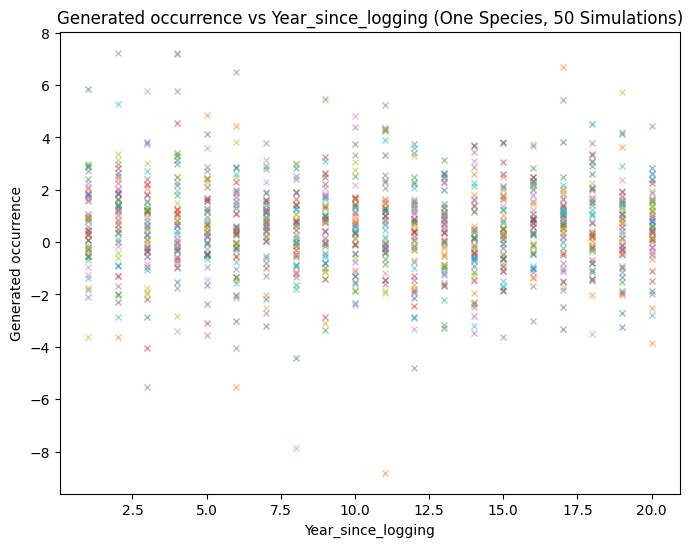

In [198]:
# Define unique years for simulation
unique_years = np.arange(1, 21)  # Adjust as per your data

# Number of simulations
n_simulations = 50

# Plotting the generated data for one species
plt.figure(figsize=(8, 6))

for i in range(n_simulations):
    # Simulating Poisson rates (lambdas) for one species from a uniform distribution between 0 and 8
    theta = np.random.beta(1, 1, size=len(unique_years))
    
    # Generating data by sampling from a Poisson distribution with the simulated lambdas
    generated_counts_one_species = np.random.logistic(theta)
    
    # Plotting the generated data for each simulation
    plt.plot(unique_years, generated_counts_one_species, marker='x', linestyle='', markersize=5, alpha=0.5)

plt.title('Generated occurrence vs Year_since_logging (One Species, 50 Simulations)')
plt.xlabel('Year_since_logging')
plt.ylabel('Generated occurrence')
plt.show()

In [201]:
Logistic_regression_Model = CmdStanModel(stan_file=os.path.join(stan_path, "logistic_occupancy.stan"))

20:30:59 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\logistic_occupancy.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\logistic_occupancy.exe
20:31:24 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\logistic_occupancy.exe
20:31:24 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
20:31:24 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/logistic_occupancy.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/logistic_occupancy.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/logistic_occupancy.stan', line 23, column 2: Declaration
    of arrays by placing brackets after a varia

In [203]:
Logistic_regression_Model_samples =  Logistic_regression_Model.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

20:31:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


20:32:00 - cmdstanpy - INFO - CmdStan done processing.


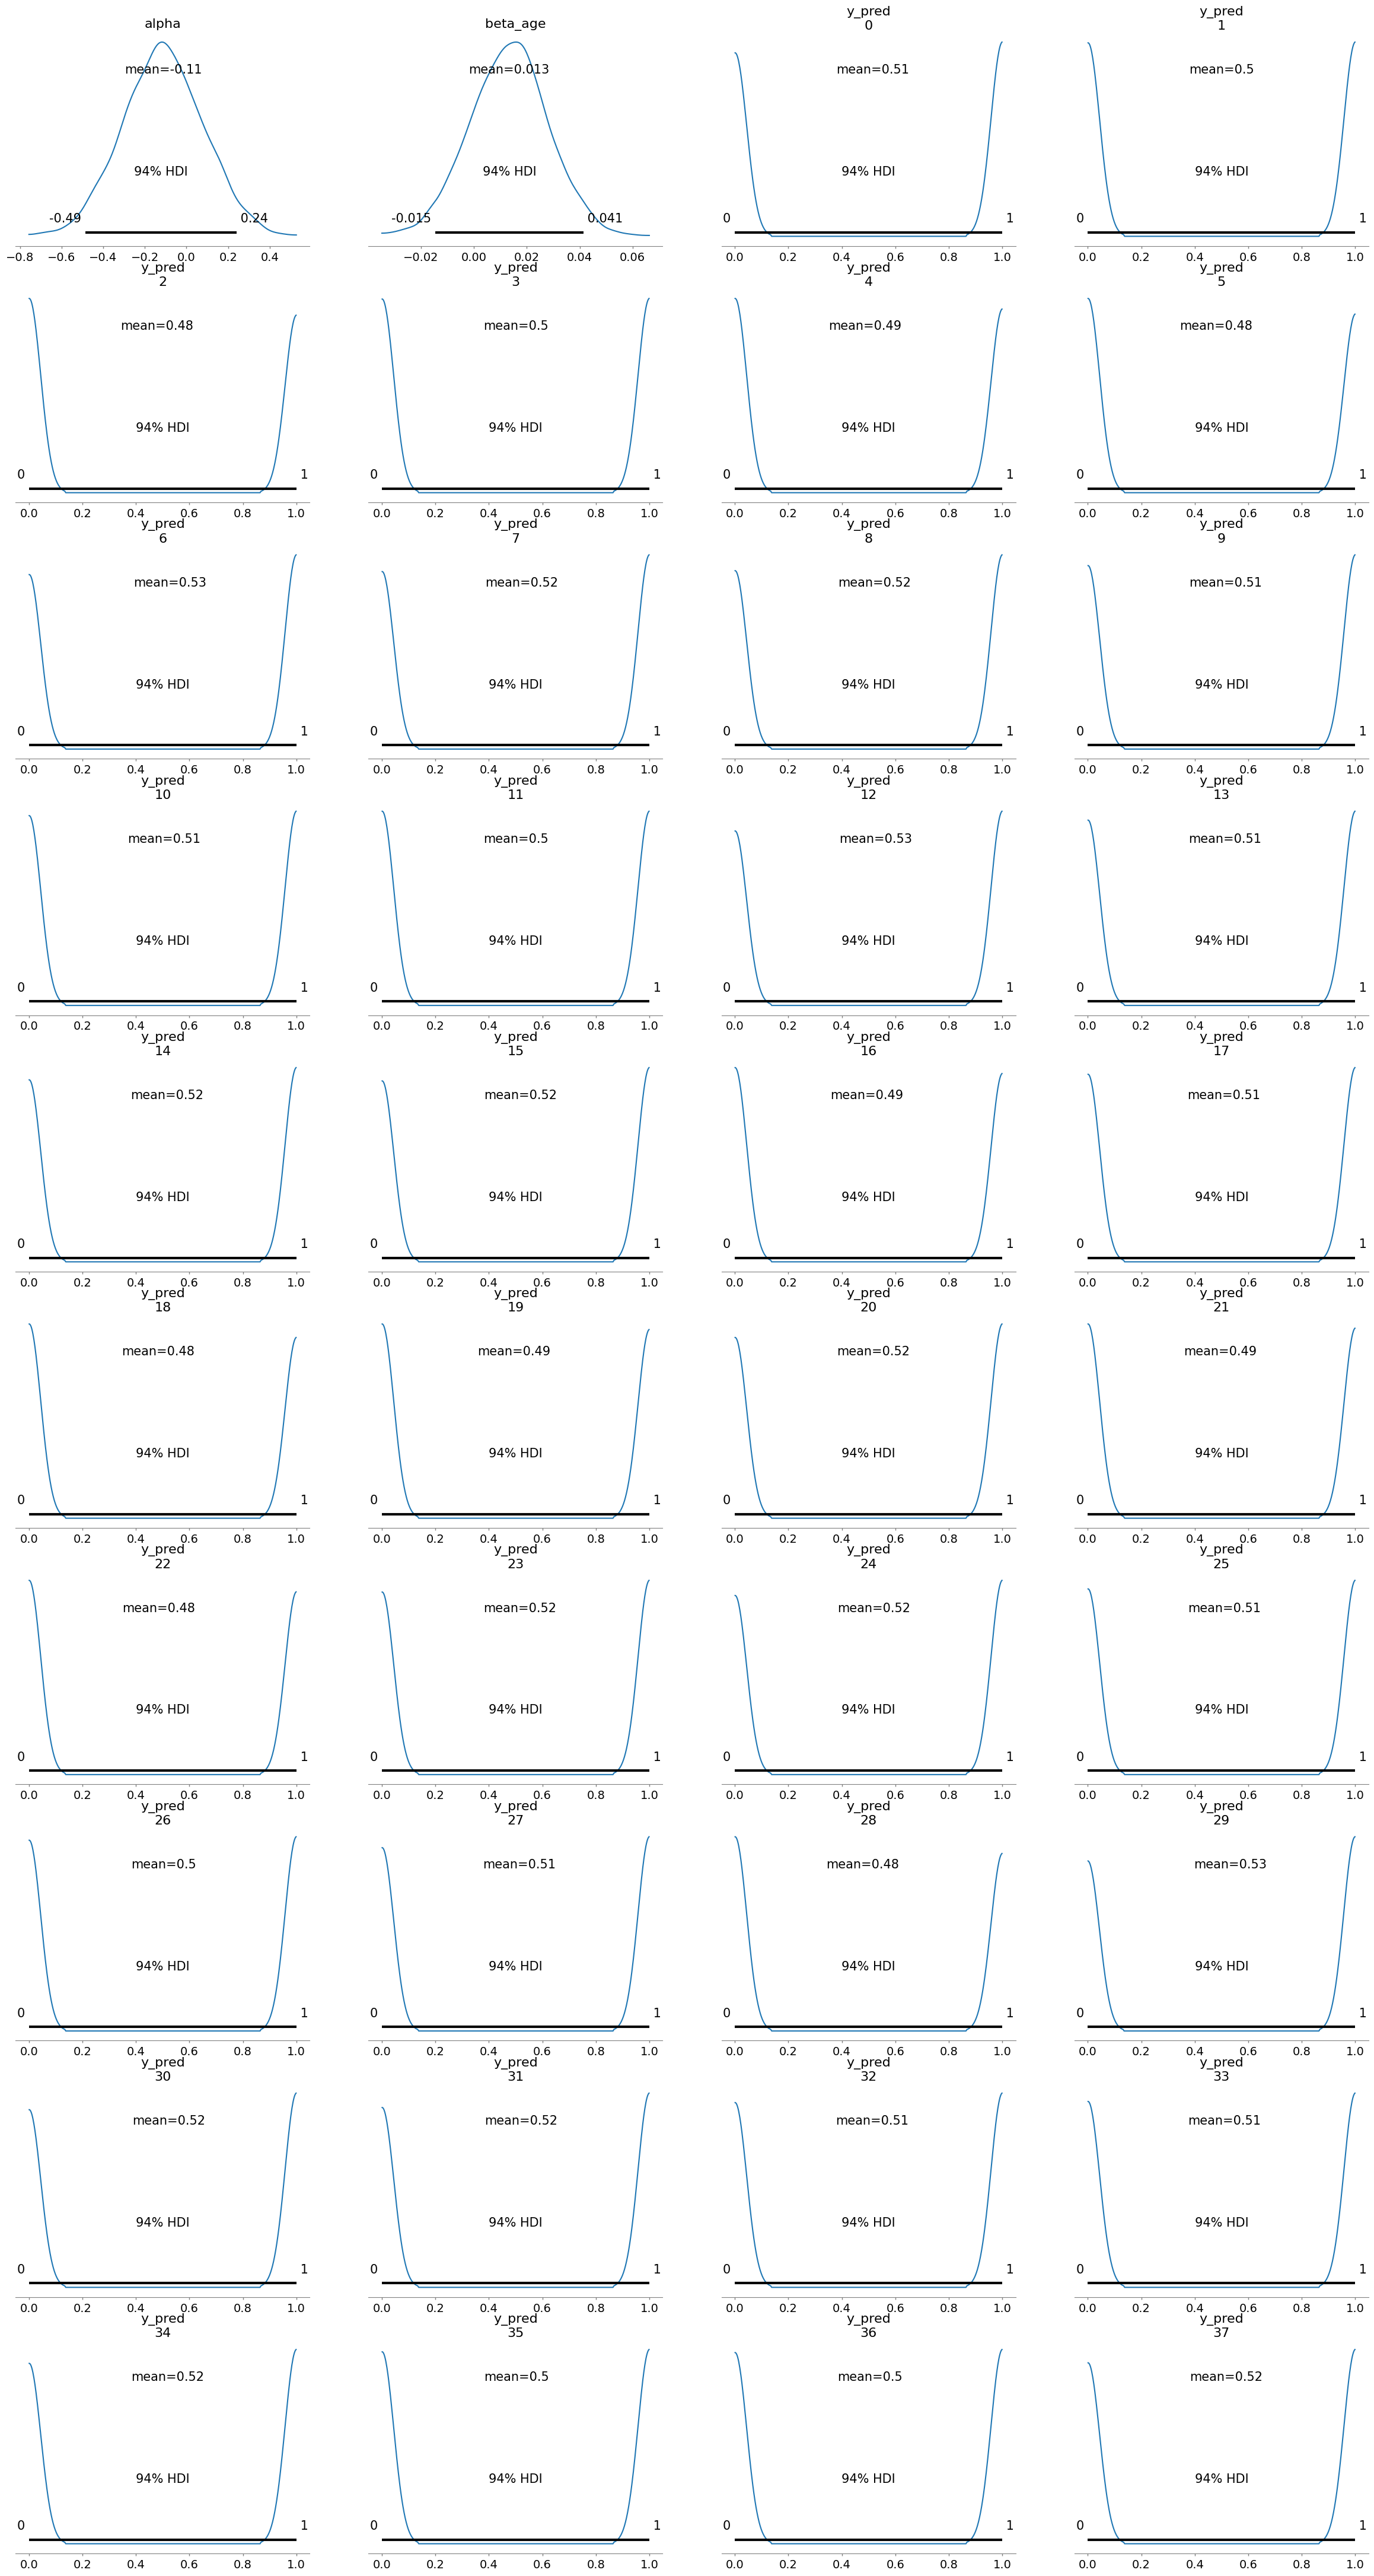

In [207]:
axes =  az.plot_posterior(Logistic_regression_Model_samples)

In [31]:
abundance_cond_occupancy = CmdStanModel(stan_file=os.path.join(stan_path, "abundance_cond_occupancy_TEST.stan"))

15:58:51 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_cond_occupancy_TEST.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_cond_occupancy_TEST.exe
15:59:15 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_cond_occupancy_TEST.exe
15:59:15 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
15:59:15 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_cond_occupancy_TEST.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_cond_occupancy_TEST.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_cond_occupancy_TEST.stan', line 4, colu

In [32]:
abundance_cond_occupancy

CmdStanModel: name=abundance_cond_occupancy_TEST
	 stan_file=C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_cond_occupancy_TEST.stan
	 exe_file=C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_cond_occupancy_TEST.exe
	 compiler_options=stanc_options={}, cpp_options={}

In [18]:
final_obs_count

location  recording_date_time  TEWA  RCKI  WTSP  YRWA  REVI  OSFL   
0     AM-429-NW  2014-05-11 08:00:00     0     0     0     0     0     0  \
1     AM-429-NW  2014-05-13 07:00:00     0     0     0     0     0     0   
2     AM-429-NW  2014-05-17 09:00:00     0     0     5     0     0     0   
3     AM-429-NW  2014-05-19 07:00:00     0     0     5     0     0     0   
4     AM-429-NW  2014-05-11 09:00:00     0     0     0     0     0     0   
...         ...                  ...   ...   ...   ...   ...   ...   ...   
3945    STB-2-3  2019-06-01 08:01:00     2     0     0     1     0     0   
3946    STB-2-3  2019-06-04 07:58:00     1     0     2     0     0     0   
3947    STB-2-3  2019-06-01 07:01:00     2     0     0     0     0     0   
3948    STB-2-3  2019-05-31 05:32:00     1     0     3     0     0     0   
3949    STB-2-3  2019-06-06 06:57:00     1     0     0     1     0     0   

      visit_number  
0                1  
1                2  
2                3  
3                4  
4                5  
...            ...  
3945             6  
3946             7  
3947             8  
3948             9  
3949            10  

[3950 rows x 9 columns]

In [169]:
[i for i in percent_spruce if i < 0]

[]

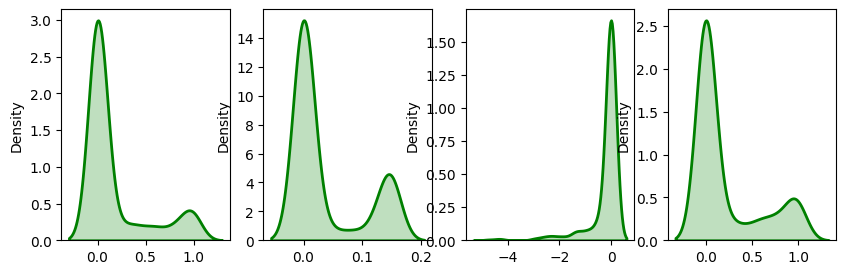

In [210]:
testing_with =percent_pine

fig, ax = plt.subplots(1, 4, figsize=(10,3))

sns.distplot(testing_with, hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
ax[0].set_title('Non-Normal Distribution')
 
sns.distplot(stats.boxcox([i+1 for i in testing_with])[0], hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
ax[1].set_title('Box-Cox Transformation')

sns.distplot([math.log(i, 10) if i != 0 else i for i in testing_with], hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[2])
ax[2].set_title('Log Transformation')

sns.distplot([math.sqrt(i) if i != 0 else i for i in testing_with], hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[3])
ax[3].set_title('Square Root Transformation')



warnings.filterwarnings('ignore')

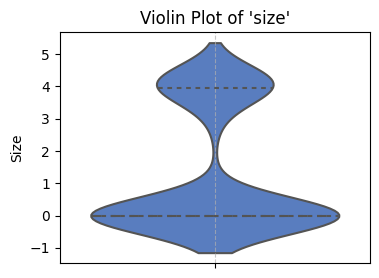

In [180]:
plt.figure(figsize=(4,3))
sns.violinplot(y=spruce_boxcox, inner="quartile", palette="muted")
plt.title("Violin Plot of 'size'")
plt.ylabel("Size")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [161]:
# Calculate the rounded mean of each site. This is a sad output, cause in the end almost everything is 1 or 0.
rounded_means = [round(sum(site_counts) / len(site_counts)) for site_counts in N_matrix_visit_num]

# Calculate the maximum count encountered at each site
max_counts = [max(site_counts) for site_counts in N_matrix_visit_num]
# Given count data per visit per site

# Collapse site occurrences into a single number per site
collapsed_occupancy = [int(any(site_counts)) for site_counts in N_matrix_visit_num]


In [162]:
obs_and_covs_dict = {
    "I": len(counts_10vis['location'].unique()),
    "J": 10,
    "N": N_matrix_visit_num,
    "y" : collapsed_occupancy,
    "M": max_counts,
    "latitude": latitude,
    "longitude": longitude,
    "percent_conifer": percent_spruce, 
    "percent_deciduous": percent_deciduous,
    "percent_pine": percent_pine,
    "size": size_log,
    "age": age,
    "time_of_day": time_of_day_matrix,
    "Julian_date": Julian_date_matrix,
}

In [211]:
occupancy_no_detectModel = CmdStanModel(stan_file=os.path.join(stan_path, "just_occupancy_no_detection.stan"))

20:46:28 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\just_occupancy_no_detection.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\just_occupancy_no_detection.exe
20:46:53 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\just_occupancy_no_detection.exe


In [215]:
occupancy_no_detect_samples = occupancy_no_detectModel.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

20:48:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00


20:48:53 - cmdstanpy - INFO - CmdStan done processing.


In [214]:
occupancy_no_detect_samples.draws_pd()

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__   
0    -274.043       0.992068    0.030198          7.0         127.0  \
1    -275.584       0.995180    0.030198          7.0         127.0   
2    -274.578       0.994796    0.030198          7.0         127.0   
3    -274.565       0.780106    0.030198          4.0          27.0   
4    -276.005       0.977308    0.030198          6.0         111.0   
...       ...            ...         ...          ...           ...   
3995 -274.334       0.932356    0.028219          7.0         127.0   
3996 -273.689       0.997415    0.028219          5.0          51.0   
3997 -274.025       0.943227    0.028219          2.0           7.0   
3998 -275.010       0.801796    0.028219          2.0           3.0   
3999 -273.795       0.991268    0.028219          2.0           7.0   

      divergent__  energy__    beta_0  beta_latitude  beta_longitude  ...   
0             0.0   274.295 -0.357021       0.004983       -0.000484  ...  \
1             0.0   276.833  0.961609       0.114099        0.061532  ...   
2             0.0   276.485  0.110991       0.151164        0.070736  ...   
3             0.0   276.738  0.147640       0.141040        0.065690  ...   
4             0.0   280.937 -0.512355      -0.030939       -0.020086  ...   
...           ...       ...       ...            ...             ...  ...   
3995          0.0   277.584  0.386364       0.036040        0.018502  ...   
3996          0.0   274.972  0.463089       0.021260        0.013513  ...   
3997          0.0   274.245  0.463915       0.020171        0.013718  ...   
3998          0.0   276.164  0.482389       0.019789        0.014384  ...   
3999          0.0   275.273  0.501856       0.021168        0.014018  ...   

      y_rep[386]  y_rep[387]  y_rep[388]  y_rep[389]  y_rep[390]  y_rep[391]   
0            NaN         NaN         NaN         NaN         NaN         NaN  \
1            NaN         NaN         NaN         NaN         NaN         NaN   
2            NaN         NaN         NaN         NaN         NaN         NaN   
3            NaN         NaN         NaN         NaN         NaN         NaN   
4            NaN         NaN         NaN         NaN         NaN         NaN   
...          ...         ...         ...         ...         ...         ...   
3995         NaN         NaN         NaN         NaN         NaN         NaN   
3996         NaN         NaN         NaN         NaN         NaN         NaN   
3997         NaN         NaN         NaN         NaN         NaN         NaN   
3998         NaN         NaN         NaN         NaN         NaN         NaN   
3999         NaN         NaN         NaN         NaN         NaN         NaN   

      y_rep[392]  y_rep[393]  y_rep[394]  y_rep[395]  
0            NaN         NaN         NaN         0.0  
1            NaN         NaN         NaN         0.0  
2            NaN         NaN         NaN         1.0  
3            NaN         NaN         NaN         0.0  
4            NaN         NaN         NaN         1.0  
...          ...         ...         ...         ...  
3995         NaN         NaN         NaN         0.0  
3996         NaN         NaN         NaN         1.0  
3997         NaN         NaN         NaN         0.0  
3998         NaN         NaN         NaN         0.0  
3999         NaN         NaN         NaN         0.0  

[4000 rows x 405 columns]

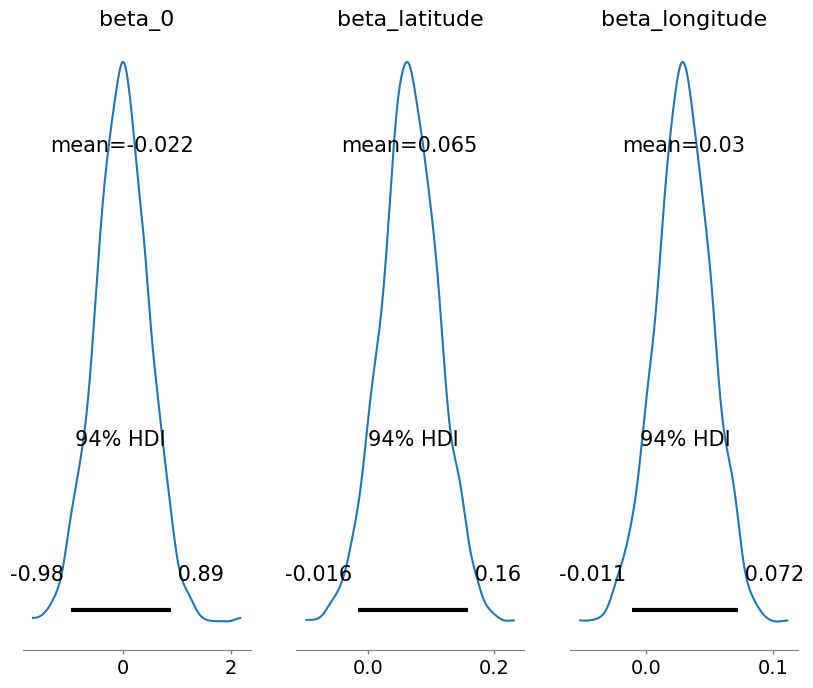

In [217]:
axes =  az.plot_posterior(occupancy_no_detect_samples, var_names = ['beta_0', 'beta_latitude', 'beta_longitude'],  figsize=(10, 8))

In [73]:
occupancy_with_detectModel = CmdStanModel(stan_file=os.path.join(stan_path, "occupancy_with_detection.stan"))


16:43:52 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\occupancy_with_detection.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\occupancy_with_detection.exe
16:44:15 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\occupancy_with_detection.exe
16:44:15 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
16:44:15 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/occupancy_with_detection.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/occupancy_with_detection.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/occupancy_with_detection.stan', line 6, column 2: Declaration
    of array

In [74]:
occupancy_with_detect_samples = occupancy_with_detectModel.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=True)

16:44:23 - cmdstanpy - INFO - Chain [1] start processing
16:44:23 - cmdstanpy - INFO - Chain [2] start processing
16:44:23 - cmdstanpy - INFO - Chain [3] start processing
16:44:23 - cmdstanpy - INFO - Chain [4] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\ilebe\AppData\Local\Temp\tmphwx7k5n7\rvirh062.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed 

16:44:57 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [2] 
Chain [2] Elapsed Time: 20.162 seconds (Warm-up)
Chain [2] 13.117 seconds (Sampling)
Chain [2] 33.279 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain

16:45:14 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [4] 
Chain [4] Elapsed Time: 23.478 seconds (Warm-up)
Chain [4] 26.949 seconds (Sampling)
Chain [4] 50.427 seconds (Total)
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 


16:45:15 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 23.822 seconds (Warm-up)
Chain [1] 27.472 seconds (Sampling)
Chain [1] 51.294 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain

16:55:22 - cmdstanpy - INFO - Chain [3] done processing


Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [3] 
Chain [3] Elapsed Time: 22.194 seconds (Warm-up)
Chain [3] 636.128 seconds (Sampling)
Chain [3] 658.322 seconds (Total)
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Cha

16:55:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 999 divergent transitions (99.9%)
	Chain 2 had 999 divergent transitions (99.9%)
	Chain 3 had 976 divergent transitions (97.6%)
	Chain 3 had 24 iterations at max treedepth (2.4%)
	Chain 4 had 1000 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


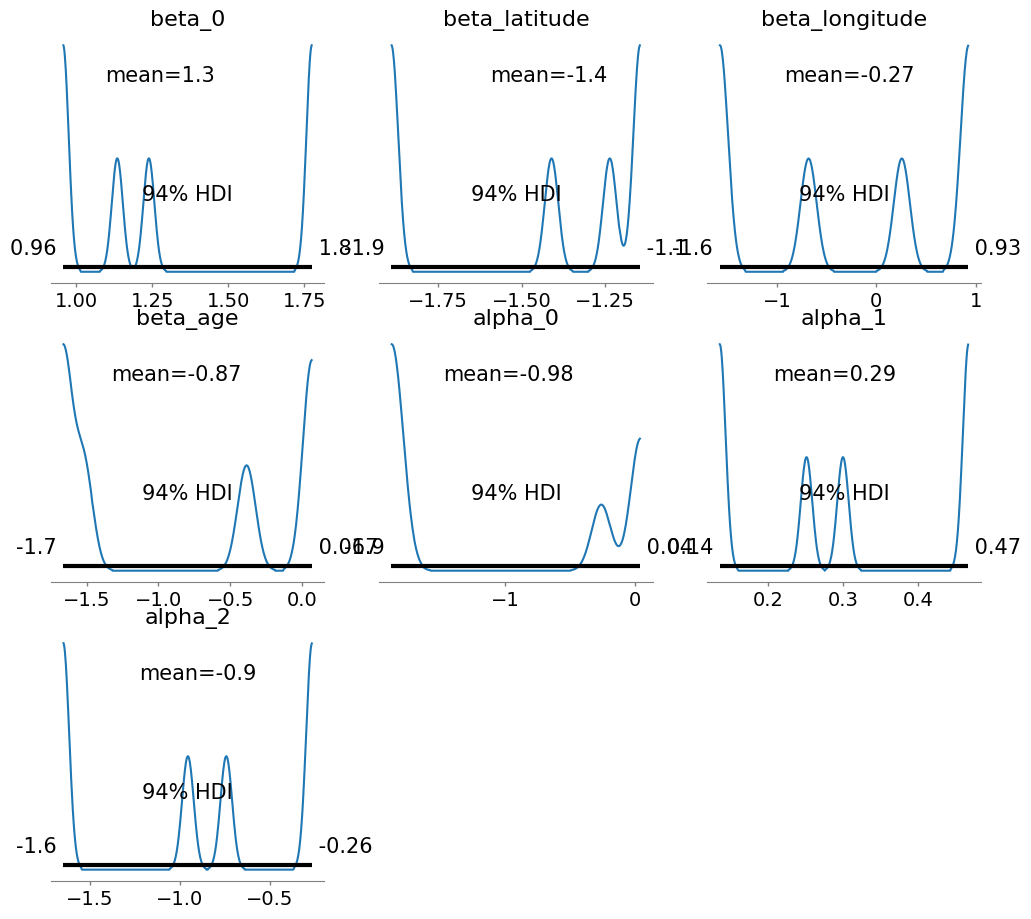

In [80]:
axes =  az.plot_posterior(occupancy_with_detect_samples, figsize=(12, 11))

In [56]:

abundance_onlyModel = CmdStanModel(stan_file=os.path.join(stan_path, "abundance_only.stan"))

16:17:17 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_only.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_only.exe
16:17:41 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_only.exe
16:17:41 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
16:17:41 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_only.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_only.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_only.stan', line 70, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated a

In [54]:

abundance_only_samples = abundance_onlyModel.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)


16:13:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |▉         | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:04 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)



16:13:20 - cmdstanpy - INFO - CmdStan done processing.


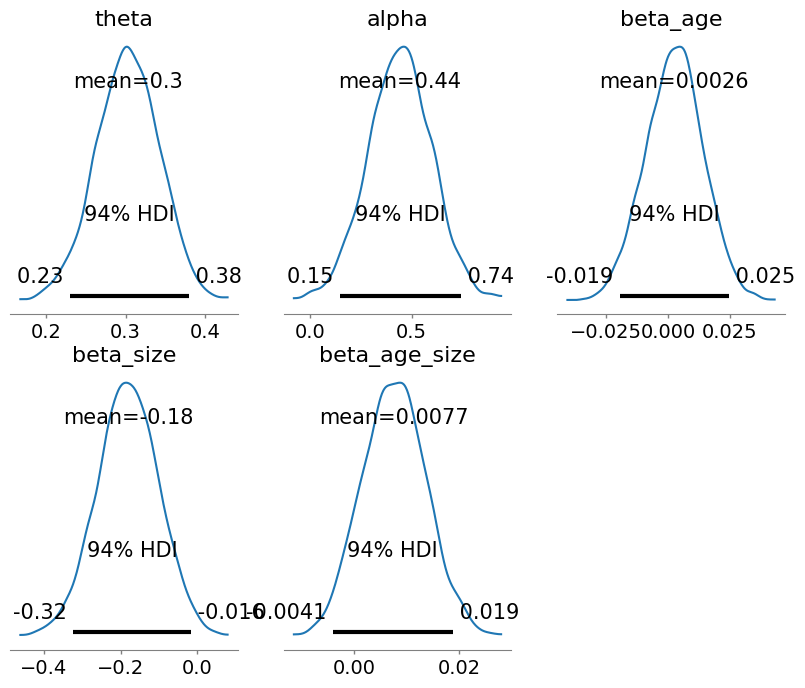

In [30]:
axes =  az.plot_posterior(abundance_only_samples, figsize=(10, 8))

In [50]:
abundance_only_samples.summary()

Mean      MCSE    StdDev          5%         50%   
lp__          -538.574000  0.044230  1.601030 -541.651000 -538.251000  \
theta            0.302698  0.000960  0.039850    0.235826    0.302762   
alpha            0.442020  0.004340  0.157578    0.179518    0.444111   
beta_age         0.002572  0.000328  0.011757   -0.017023    0.002738   
beta_size       -0.180921  0.002214  0.081450   -0.315322   -0.180666   
beta_age_size    0.007653  0.000167  0.006092   -0.002355    0.007639   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__          -536.645000  1310.27   81.1060  1.00134  
theta            0.367227  1723.42  106.6800  1.00146  
alpha            0.699453  1318.25   81.6002  1.00195  
beta_age         0.021736  1283.68   79.4604  1.00164  
beta_size       -0.047701  1353.58   83.7873  0.99983  
beta_age_size    0.017824  1331.82   82.4400  1.00003

In [51]:
abundance_only_samples.draws_pd()

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__   
0    -537.238       0.975980    0.162396          4.0          23.0  \
1    -538.274       0.965023    0.162396          4.0          15.0   
2    -536.460       0.977008    0.162396          4.0          15.0   
3    -536.671       0.776341    0.162396          4.0          15.0   
4    -537.596       0.963559    0.162396          5.0          31.0   
...       ...            ...         ...          ...           ...   
3995 -539.449       0.960941    0.183958          4.0          31.0   
3996 -541.089       0.986015    0.183958          3.0           7.0   
3997 -540.433       0.999204    0.183958          4.0          15.0   
3998 -540.375       0.992002    0.183958          4.0          31.0   
3999 -538.465       0.991536    0.183958          4.0          15.0   

      divergent__  energy__     theta     alpha  beta_age  beta_size   
0             0.0   542.763  0.279134  0.408669  0.001498  -0.137332  \
1             0.0   540.432  0.302052  0.459347  0.009994  -0.277452   
2             0.0   540.335  0.288477  0.479485  0.002171  -0.207162   
3             0.0   544.240  0.326938  0.464968  0.004657  -0.122702   
4             0.0   537.936  0.302088  0.233296  0.020049  -0.127807   
...           ...       ...       ...       ...       ...        ...   
3995          0.0   542.386  0.253103  0.639480 -0.009270  -0.363250   
3996          0.0   541.870  0.241224  0.650934 -0.010582  -0.411378   
3997          0.0   542.133  0.243853  0.668911 -0.013003  -0.396668   
3998          0.0   543.148  0.213228  0.455669 -0.007613  -0.308288   
3999          0.0   541.887  0.225724  0.524309 -0.007445  -0.250144   

      beta_age_size  
0          0.007499  
1          0.011649  
2          0.009564  
3          0.002754  
4          0.004503  
...             ...  
3995       0.019055  
3996       0.021154  
3997       0.021035  
3998       0.018877  
3999       0.011511  

[4000 rows x 12 columns]

CmdStan saves the draws from each chain in separate CSV files.
bundance_cond_occupancy_samples.draws_pd<br>
<bound method CmdStanMCMC.draws_pd of CmdStanMCMC: model=abundance_cond_uccpuancy_TEST chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_1.csv
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_2.csv
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_3.csv
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_4.csv
 output_files:
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_0-stdout.txt
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_1-stdout.txt
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_2-stdout.txt
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_3-stdout.txt>

In [59]:
# Extracting the predicted counts from the samples
predicted_counts = abundance_only_samples.stan_variable('predicted_counts')
type(predicted_counts)

numpy.ndarray

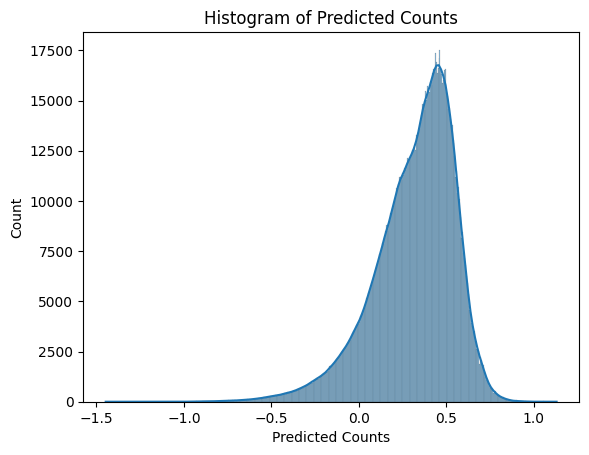

In [60]:

# Plotting histogram of predicted counts
sns.histplot(predicted_counts.flatten(), kde=True)
plt.title('Histogram of Predicted Counts')
plt.xlabel('Predicted Counts')
plt.show()

This model does a very bad job at predicting the counts, looking at the difference in the observed and predicted counts.

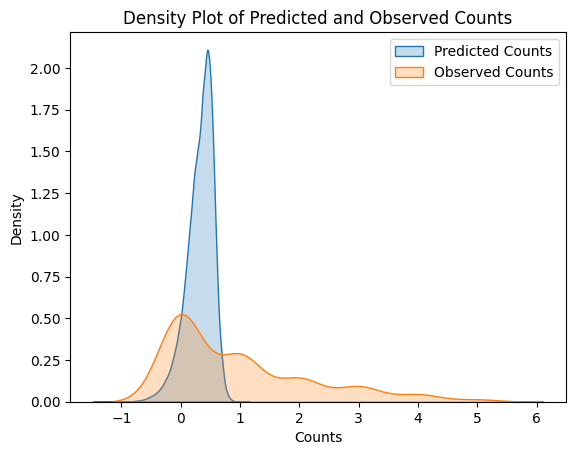

In [61]:
# Assuming obs_and_covs_dict contains 'M' as observed counts
observed_counts = obs_and_covs_dict['M']

# Plotting kernel density estimates of predicted and observed counts
sns.kdeplot(predicted_counts.flatten(), fill=True, label='Predicted Counts')
sns.kdeplot(observed_counts, fill=True, label='Observed Counts')
plt.title('Density Plot of Predicted and Observed Counts')
plt.xlabel('Counts')
plt.legend()
plt.show()


In [66]:
obs_and_covs_dict.keys()

dict_keys(['I', 'J', 'N', 'y', 'M', 'latitude', 'longitude', 'percent_conifer', 'percent_deciduous', 'percent_pine', 'size', 'age', 'time_of_day', 'Julian_date'])

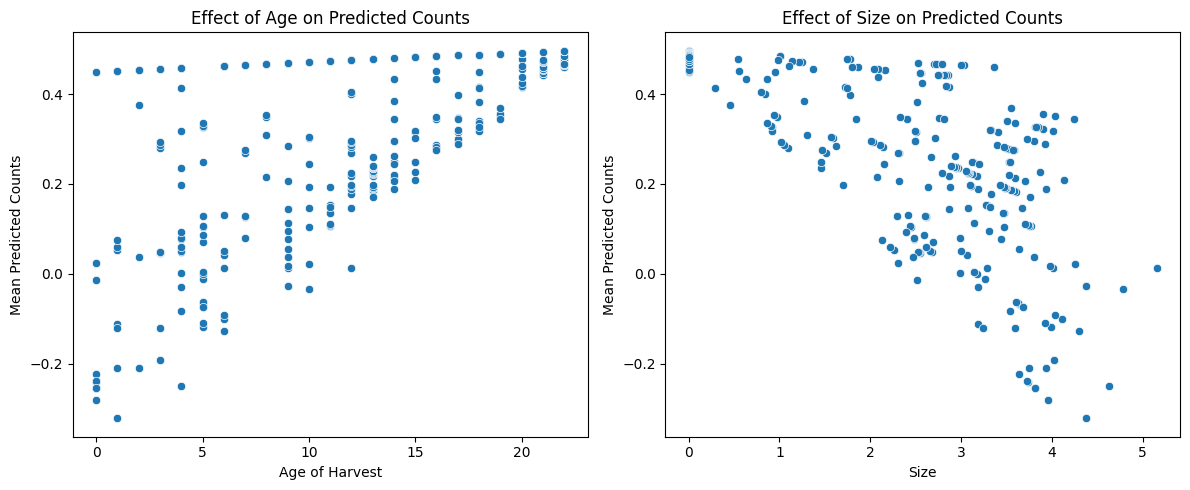

In [72]:

# Create a figure with 3 subplots: 1 row, 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
mean_predicted_counts = np.mean(predicted_counts, axis=0)
age_of_harv = obs_and_covs_dict['age']
size = obs_and_covs_dict['size']
# Plot 1: Effect of age_of_harv on mean_predicted_counts
sns.scatterplot(x=age_of_harv, y=mean_predicted_counts, ax=axes[0])
axes[0].set_title('Effect of Age on Predicted Counts')
axes[0].set_xlabel('Age of Harvest')
axes[0].set_ylabel('Mean Predicted Counts')

# Plot 2: Effect of size on mean_predicted_counts
sns.scatterplot(x=size, y=mean_predicted_counts, ax=axes[1])
axes[1].set_title('Effect of Size on Predicted Counts')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Mean Predicted Counts')

# Display the plots
plt.tight_layout()
plt.show()


In [32]:
# Assuming `abundance_only_samples` is the output from the sampling
age_posteior = abundance_only_samples.beta_age


In [44]:
# Generate a range of age values
age_values = np.linspace(0, 22, 100)

# Calculate the predicted abundance for each age value and each sample from the posterior
predicted_abundance = np.exp(
    abundance_only_samples.alpha +
    abundance_only_samples.beta_age * age_values[:, None, None]
    # add other terms as necessary, using fixed values for other variables
)

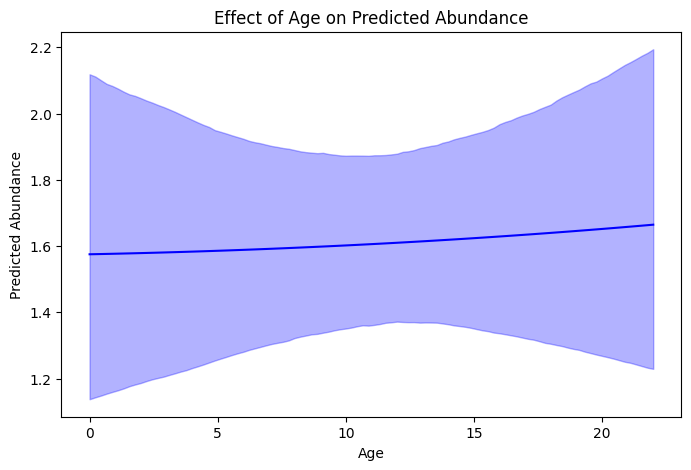

In [42]:
# Calculate summary statistics
mean_predicted_abundance = np.mean(predicted_abundance, axis=-1)
lower_bound = np.squeeze(np.percentile(predicted_abundance, 2.5, axis=-1))
upper_bound = np.squeeze(np.percentile(predicted_abundance, 97.5, axis=-1))

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(age_values, mean_predicted_abundance, color='blue')
plt.fill_between(age_values, lower_bound, upper_bound, color='blue', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Predicted Abundance')
plt.title('Effect of Age on Predicted Abundance')
plt.show()


In [135]:
pickle.dump(bundance_cond_occupancy_samples, file=open('abundance_cond_occupancy_samples_trial', 'wb'))

In [136]:
bundance_cond_occupancy_samples.summary()

Mean       MCSE     StdDev           5%          50%   
lp__             -6255.270000  33.147200  47.193800 -6328.740000 -6254.020000  \
beta0_psi            1.228760   0.411095   0.583205     0.268358     1.400310   
beta1_psi            0.016954   0.019086   0.039054    -0.043237     0.013960   
beta2_psi            0.018976   0.011725   0.021049    -0.011971     0.016609   
beta_conifer_psi     0.000003   0.000003   0.000005    -0.000006     0.000003   
...                       ...        ...        ...          ...          ...   
y_rep[395,6]         0.513250   0.007790   0.499887     0.000000     1.000000   
y_rep[395,7]         0.505000   0.008130   0.500038     0.000000     1.000000   
y_rep[395,8]         0.494250   0.007911   0.500029     0.000000     0.000000   
y_rep[395,9]         0.504750   0.007886   0.500040     0.000000     1.000000   
y_rep[395,10]        0.500000   0.008008   0.500063     0.000000     1.000000   

                          95%       N_Eff   N_Eff/s      R_hat  
lp__             -6186.900000     2.02710  0.000208  11.784700  
beta0_psi            1.862660     2.01260  0.000207  29.095800  
beta1_psi            0.083013     4.18701  0.000430   1.415600  
beta2_psi            0.055615     3.22279  0.000331   1.646320  
beta_conifer_psi     0.000011     3.20976  0.000330   1.578840  
...                       ...         ...       ...        ...  
y_rep[395,6]         1.000000  4117.38000  0.422879   1.000570  
y_rep[395,7]         1.000000  3783.12000  0.388548   1.001290  
y_rep[395,8]         1.000000  3994.99000  0.410309   1.000400  
y_rep[395,9]         1.000000  4021.02000  0.412983   1.000930  
y_rep[395,10]        1.000000  3899.11000  0.400461   0.999749  

[14634 rows x 9 columns]

In [145]:
bundance_cond_occupancy_samples.diagnose()

'Processing csv files: C:\\Users\\ilebe\\AppData\\Local\\Temp\\tmptv7xutp2\\abundance_cond_uccpuancy_TEST925j_pdy\\abundance_cond_uccpuancy_TEST-20230914192106_1.csv, C:\\Users\\ilebe\\AppData\\Local\\Temp\\tmptv7xutp2\\abundance_cond_uccpuancy_TEST925j_pdy\\abundance_cond_uccpuancy_TEST-20230914192106_2.csv, C:\\Users\\ilebe\\AppData\\Local\\Temp\\tmptv7xutp2\\abundance_cond_uccpuancy_TEST925j_pdy\\abundance_cond_uccpuancy_TEST-20230914192106_3.csv, C:\\Users\\ilebe\\AppData\\Local\\Temp\\tmptv7xutp2\\abundance_cond_uccpuancy_TEST925j_pdy\\abundance_cond_uccpuancy_TEST-20230914192106_4.csv\n\nChecking sampler transitions treedepth.\n4000 of 4000 (100.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler trans

In [139]:
bundance_cond_occupancy_samples.draws_xr

<bound method CmdStanMCMC.draws_xr of CmdStanMCMC: model=abundance_cond_uccpuancy_TEST chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_1.csv
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_2.csv
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_3.csv
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_4.csv
 output_files:
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_0-stdout.txt
	C:\Users\ilebe\AppData\Local\Temp\tmptv7xutp2\abundance_cond_uccpuancy_TEST925j_pdy\abundance_cond_uccpuancy_TEST-20230914192106_1-st

In [ ]:
sigma_post = bundance_cond_occupancy_samples.draws_pd(
    vars=["sigma_spp", "sigma_sites", "sigma_obs"]
)

## Prameters of interest:
# - beta0_psi;  // intercept for occupancy
# - beta1_psi;  // coefficient for latitude
# - real beta2_psi;  // coefficient for longitude

# - beta_size // coefficient for size
# - beta_age;   // coefficient for age

In [144]:
bundance_cond_occupancy_samples.draws_pd('beta1_psi')

beta1_psi
0     -0.007838
1      0.002397
2     -0.002192
3      0.012918
4      0.033338
...         ...
3995  -0.012309
3996  -0.019928
3997   0.006478
3998   0.005840
3999   0.009386

[4000 rows x 1 columns]

Visualisation of some key draws

In [156]:
vars_of_interest = ["beta0_psi", "beta1_psi", "beta2_psi", "beta_size", "beta_age",
          "beta_conifer_psi", "beta_deciduous_psi", "beta_pine_psi",
          "beta_conifer_lambda", "beta_deciduous_lambda", "beta_pine_lambda",
          ]
key_draws_post = bundance_cond_occupancy_samples.draws_pd(
    vars=["beta0_psi", "beta1_psi", "beta2_psi", "beta_size", "beta_age",
          "beta_conifer_psi", "beta_deciduous_psi", "beta_pine_psi",
          "beta_conifer_lambda", "beta_deciduous_lambda", "beta_pine_lambda",

          ]
)

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

array([[<Axes: title={'center': 'beta0_psi'}>,
        <Axes: title={'center': 'beta1_psi'}>,
        <Axes: title={'center': 'beta2_psi'}>],
       [<Axes: title={'center': 'beta_size'}>,
        <Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_conifer_psi'}>],
       [<Axes: title={'center': 'beta_deciduous_psi'}>,
        <Axes: title={'center': 'beta_pine_psi'}>,
        <Axes: title={'center': 'beta_conifer_lambda'}>],
       [<Axes: title={'center': 'beta_deciduous_lambda'}>,
        <Axes: title={'center': 'beta_pine_lambda'}>, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

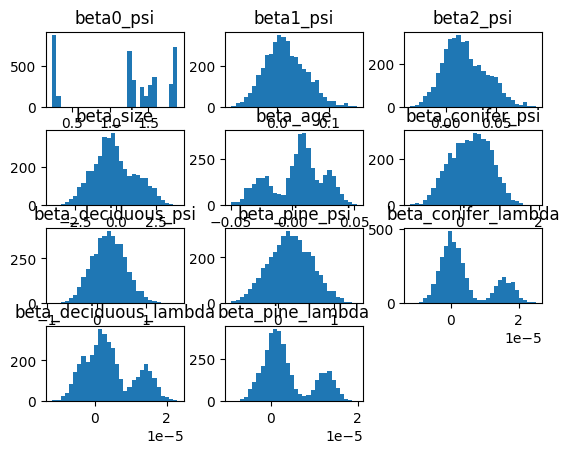

In [154]:
plt.tight_layout()
key_draws_post.hist(grid=False, bins=30)

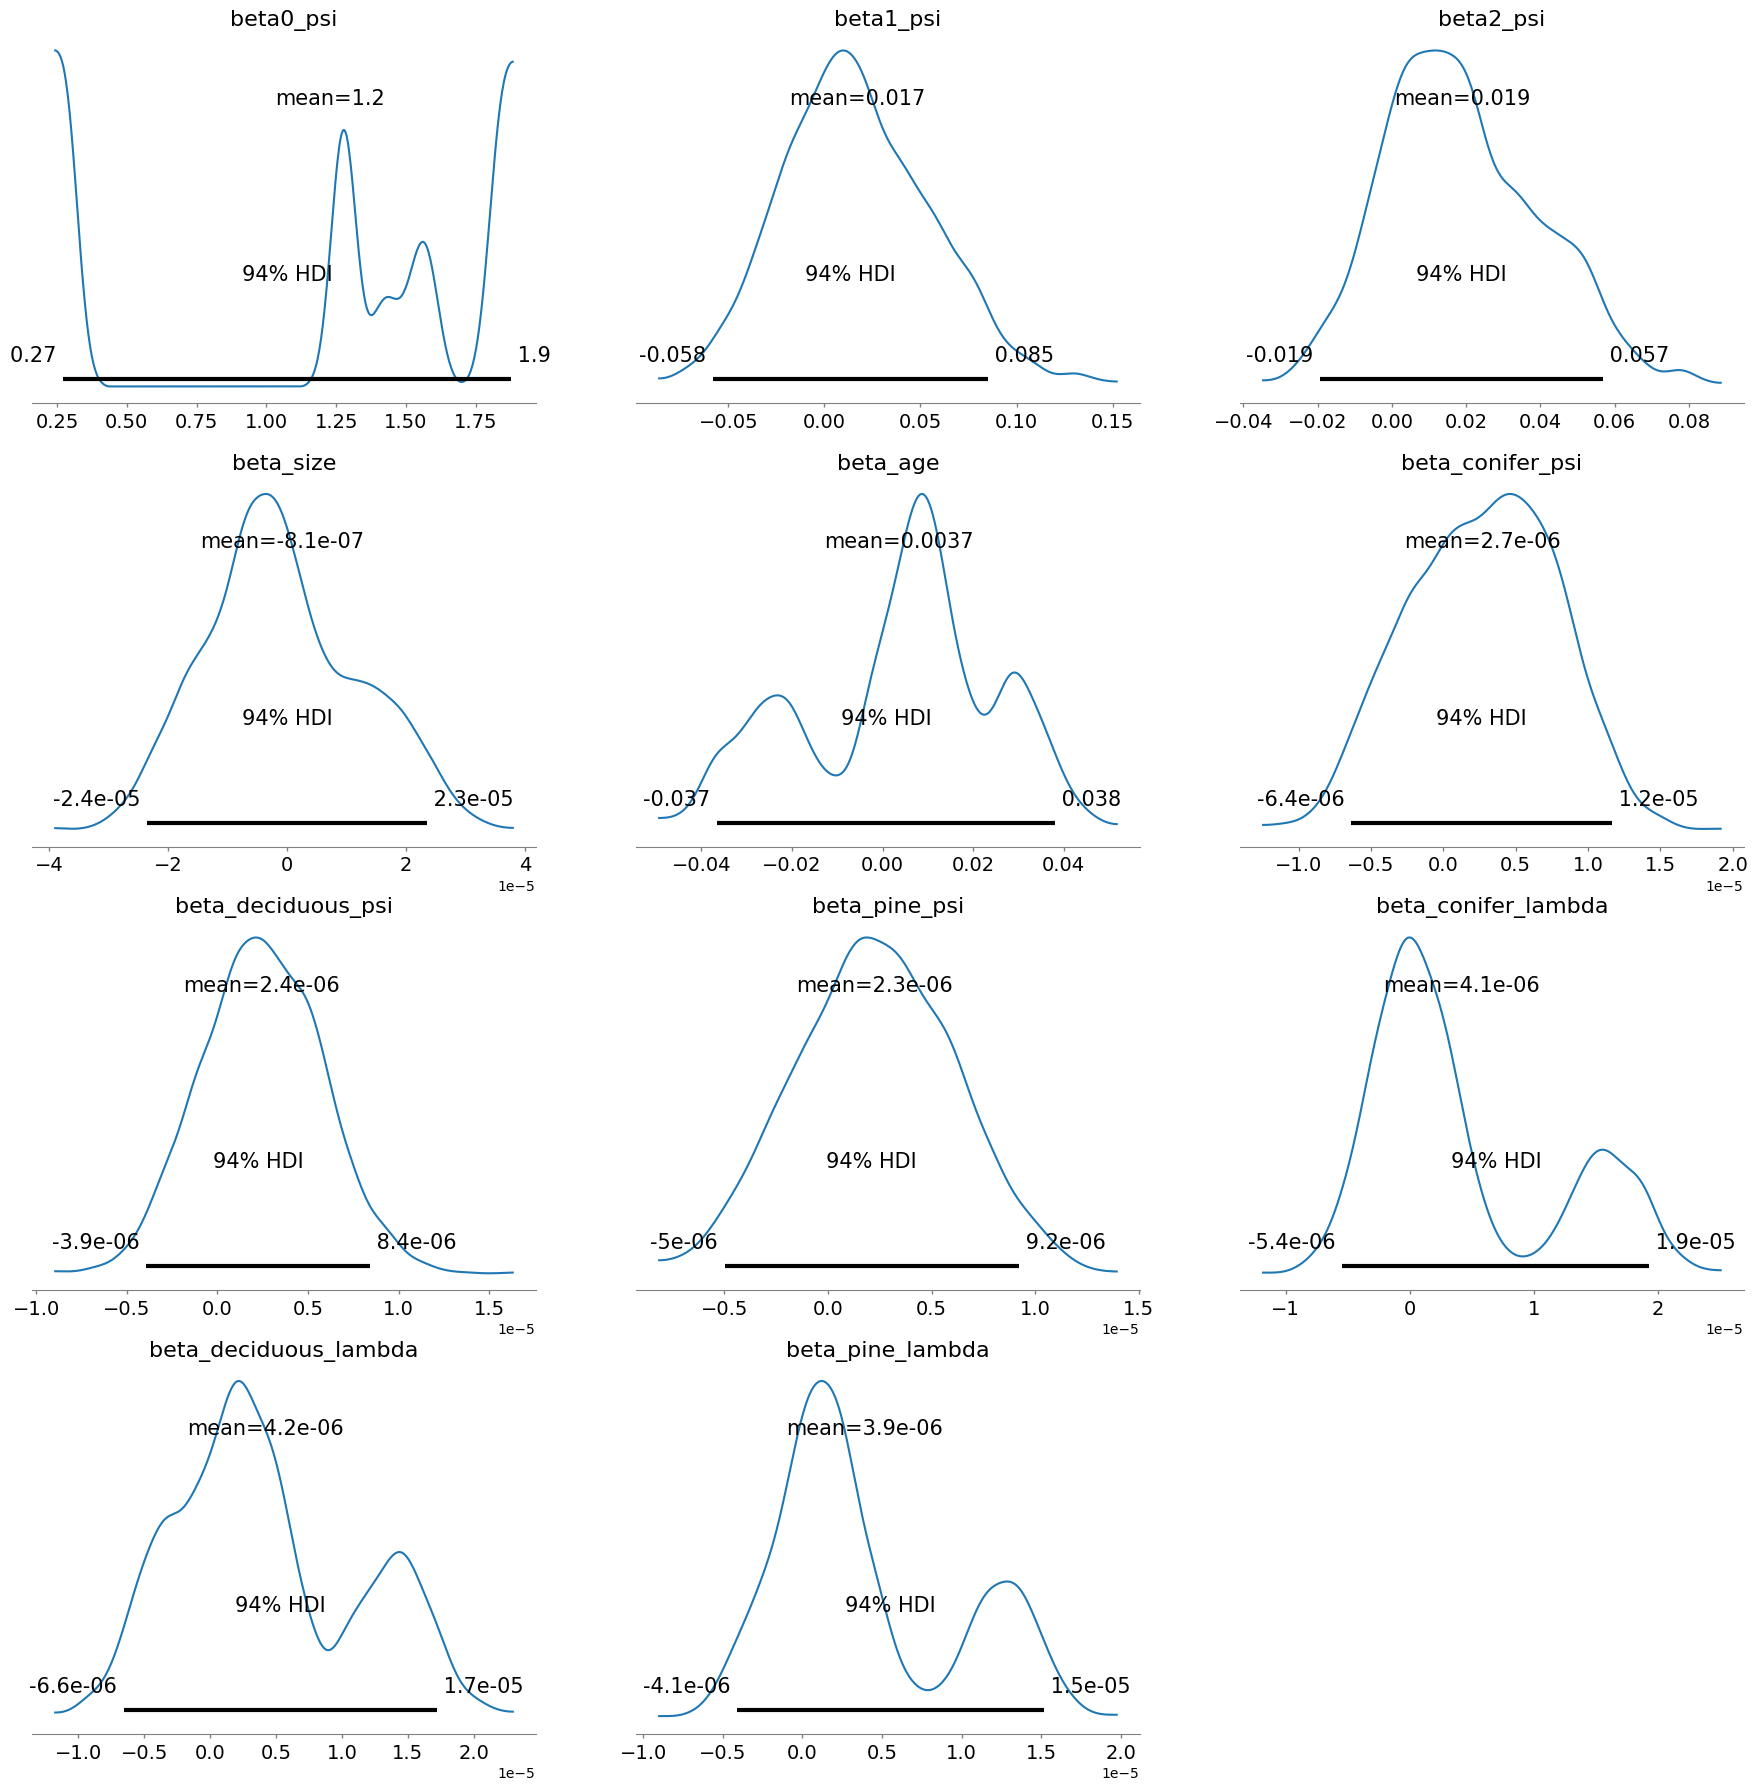

In [164]:
axes =  az.plot_posterior(bundance_cond_occupancy_samples, var_names = vars_of_interest)
TEWA_posterior_graphs = axes[0, 0].figure
type(TEWA_posterior_graphs)
TEWA_posterior_graphs.savefig(os.path.join(trial1_output_location_for_TEWA,'TEWA_t1_posterior_plot.png'))

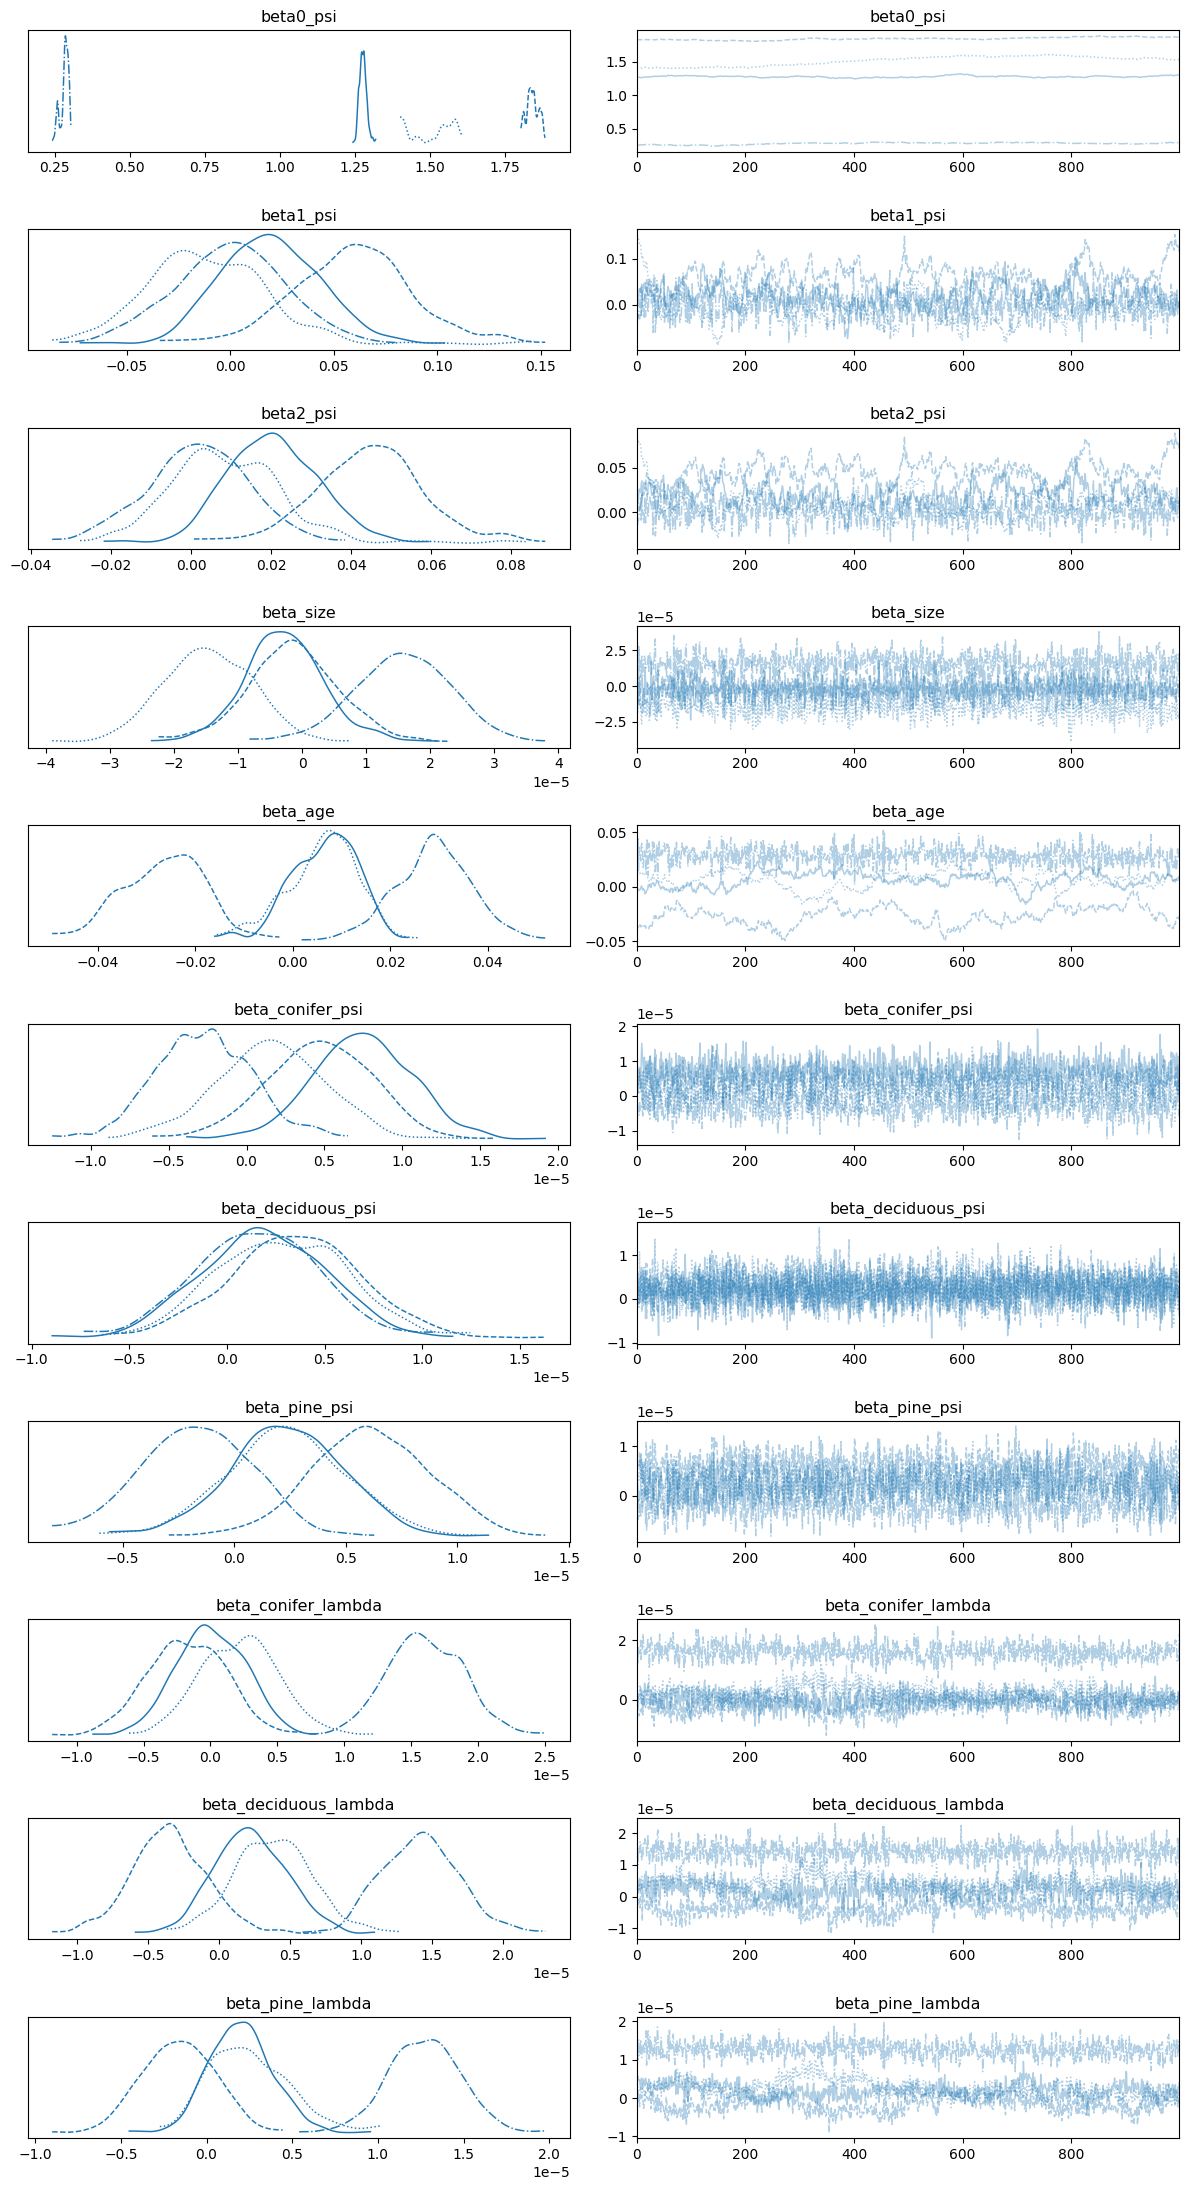

In [169]:

axes = az.plot_trace(bundance_cond_occupancy_samples, var_names = vars_of_interest)
TEWA_t1_trace_plots = axes[0,0].figure
type(TEWA_t1_trace_plots)
plt.tight_layout()
TEWA_t1_trace_plots.savefig(os.path.join(trial1_output_location_for_TEWA,'TEWA_t1_trace_plots.png'))

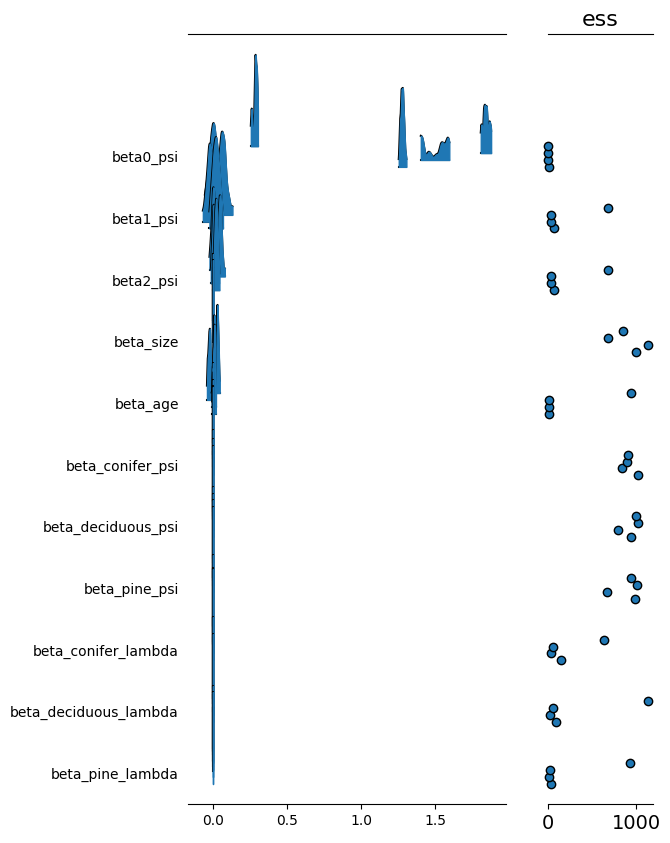

In [177]:
axes = az.plot_forest(bundance_cond_occupancy_samples, var_names = vars_of_interest, kind = "ridgeplot", hdi_prob=0.95, ess = True, figsize = (6, 10))
TEWAt1_forest_plots = axes[0].figure
TEWAt1_forest_plots.savefig(os.path.join(trial1_output_location_for_TEWA,'TEWA_t1_forest_plots.png'))

c:\Users\ilebe\anaconda3\envs\stan\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_autocorr, generating only 40 plots
  warnings.warn(


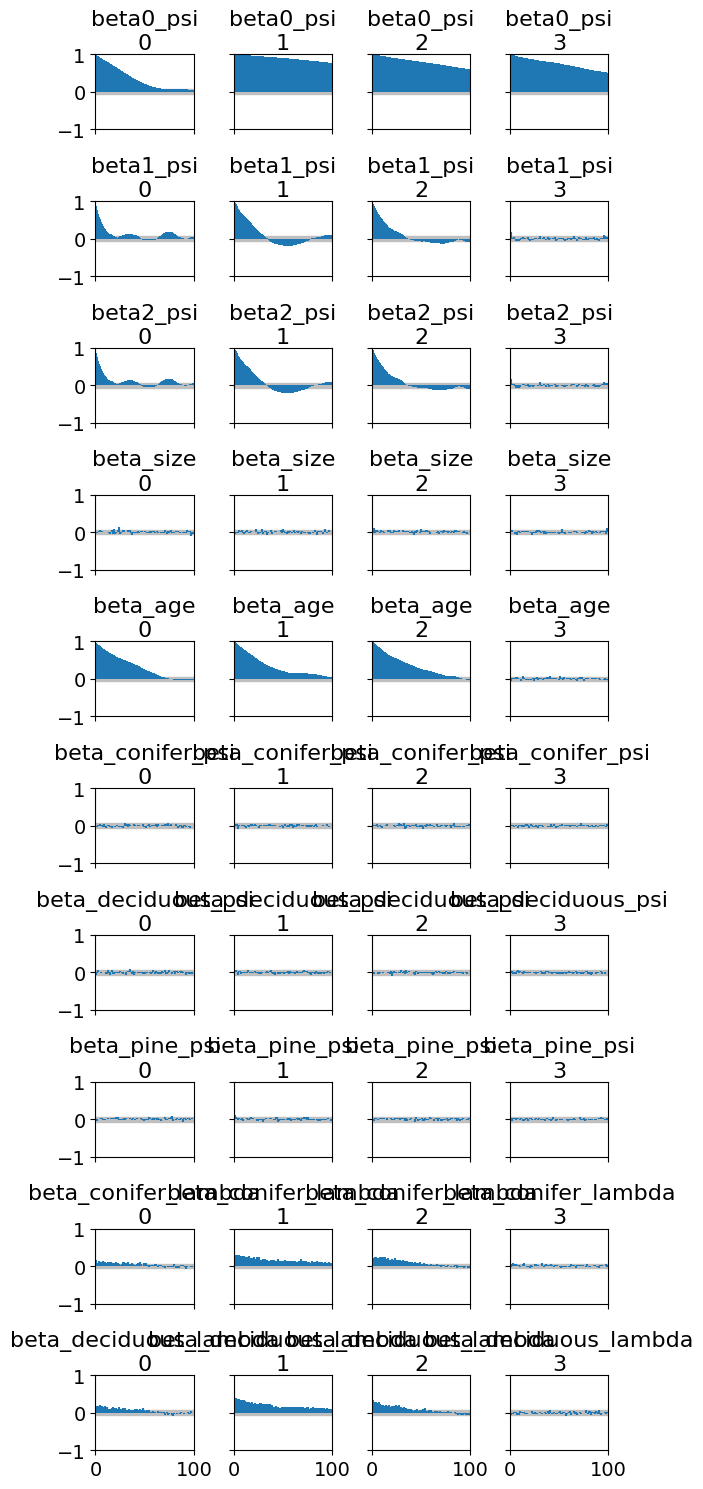

In [182]:
axes = az.plot_autocorr(bundance_cond_occupancy_samples, var_names = vars_of_interest, figsize = (6, 15))
TEWAt1_autocorr_plots = axes[0, 0].figure
plt.tight_layout()

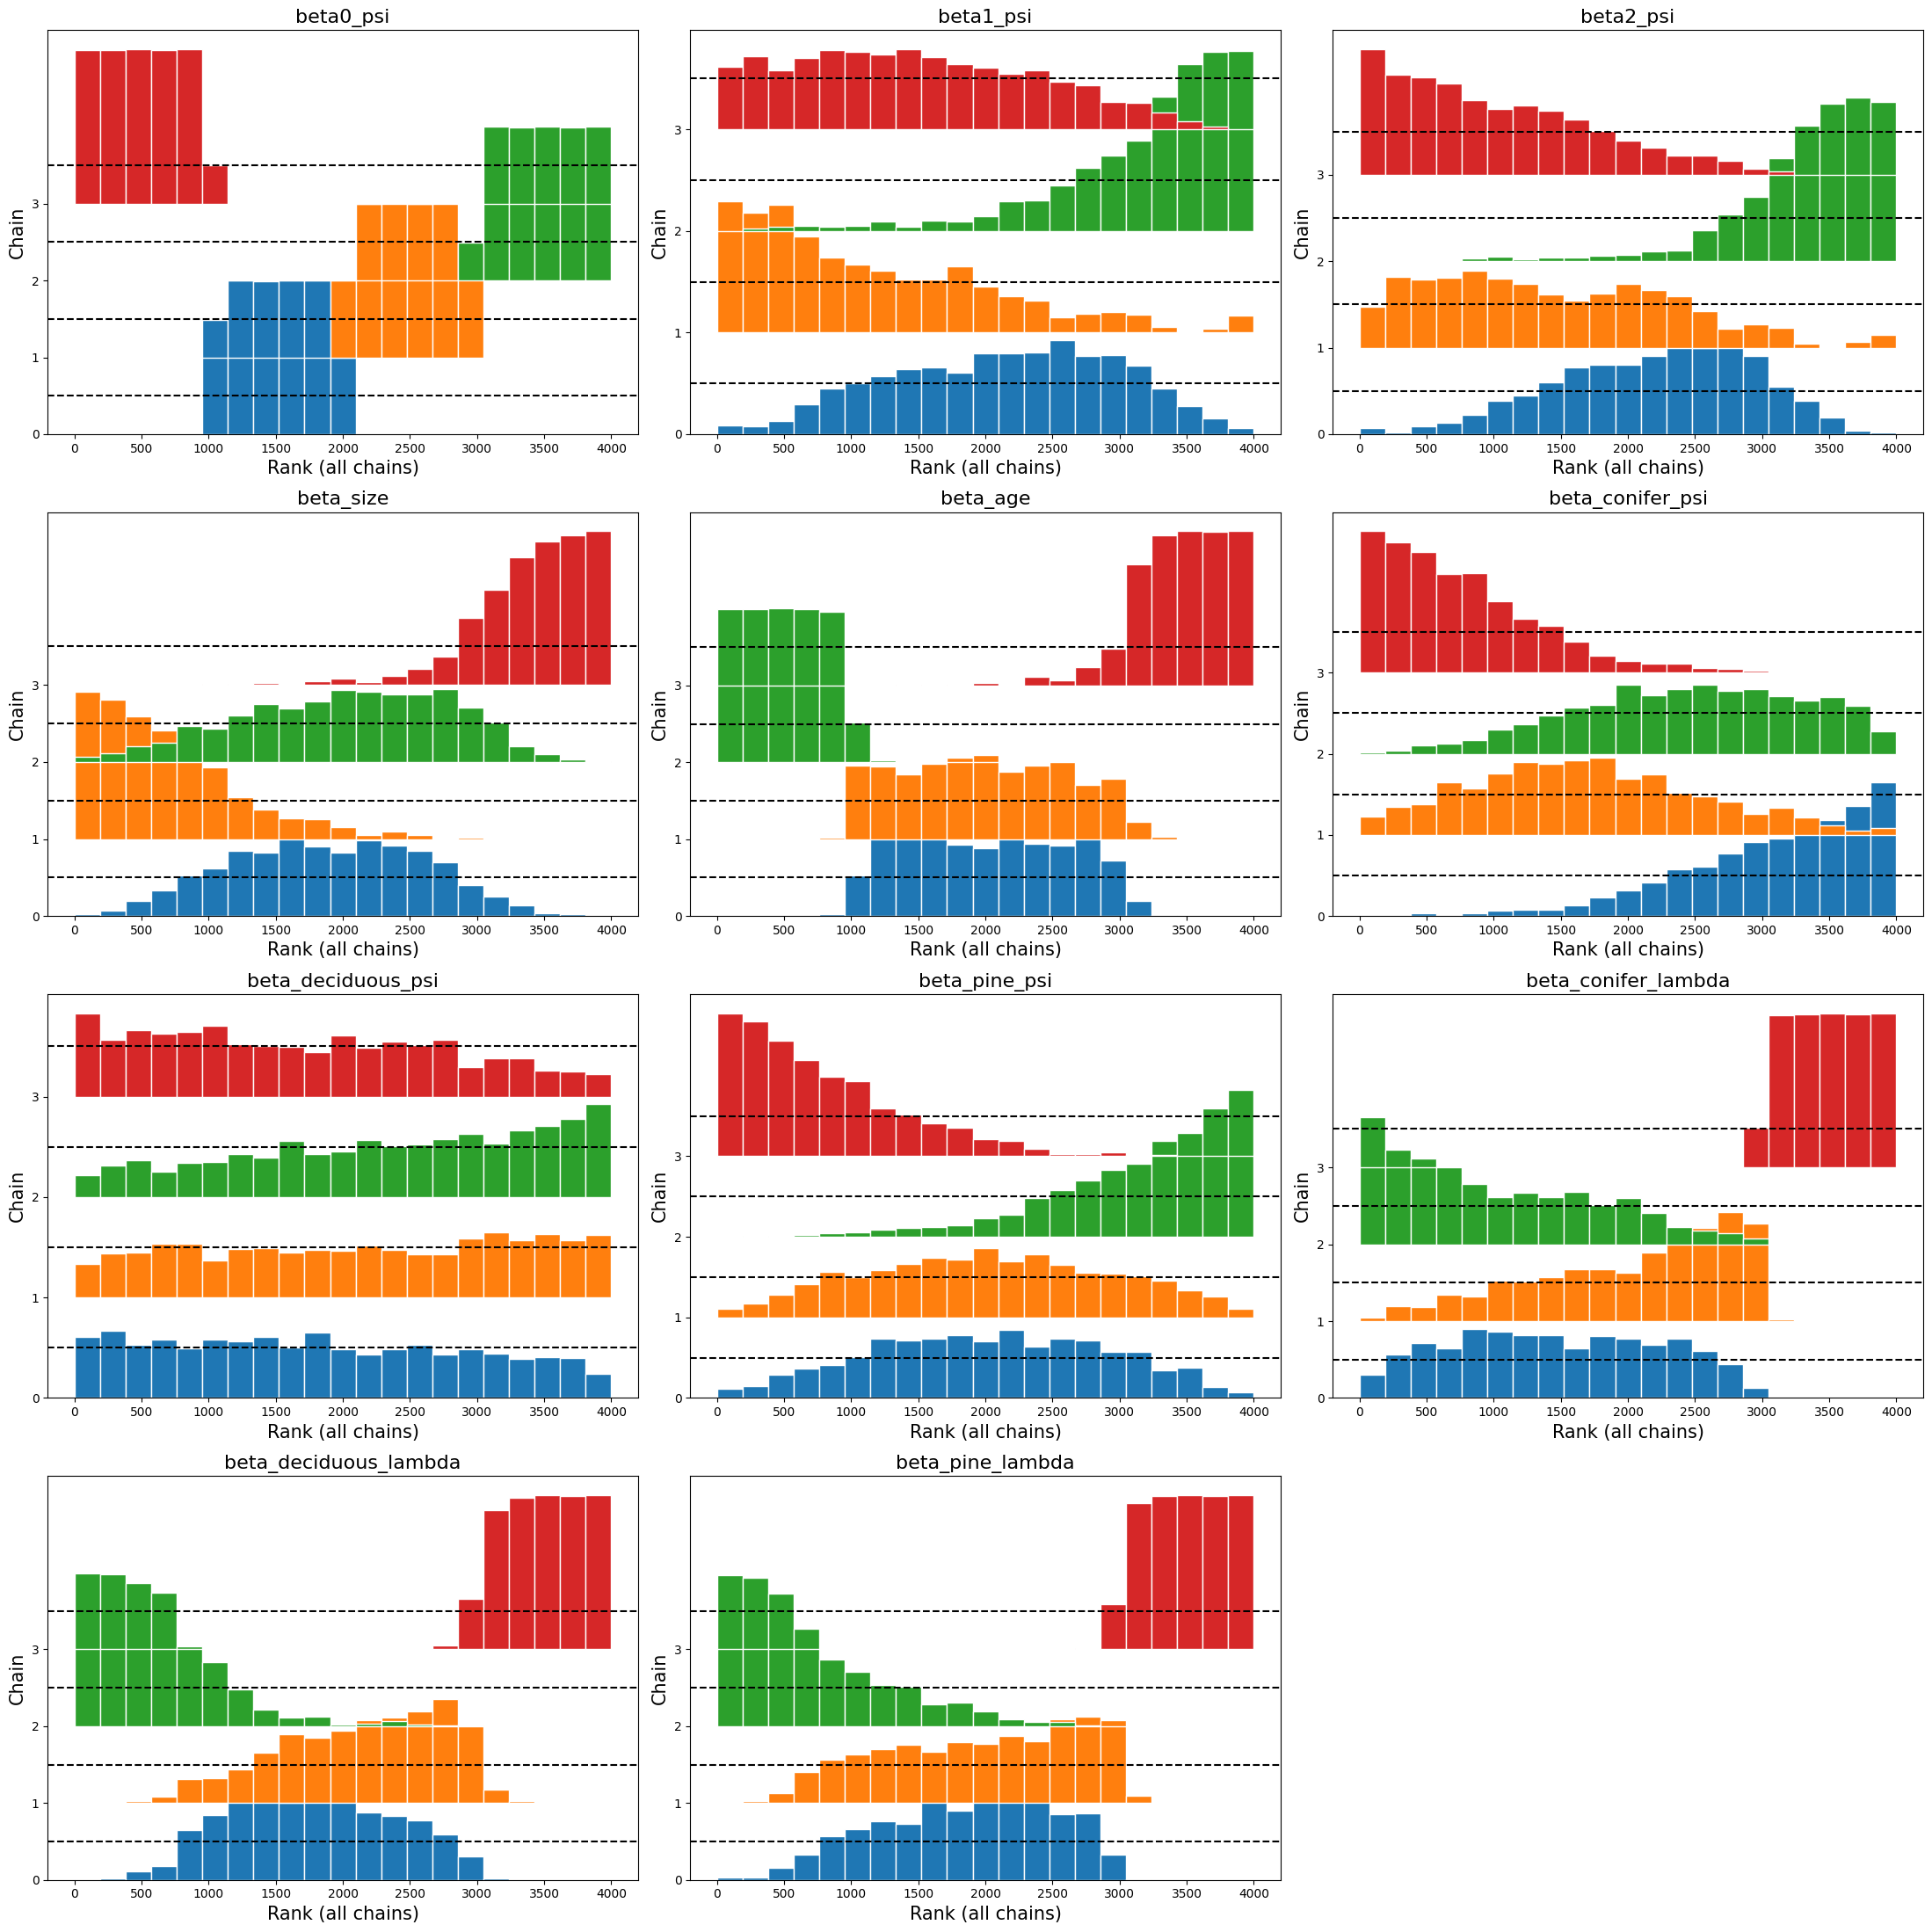

In [184]:
axes = az.plot_rank(bundance_cond_occupancy_samples, var_names = vars_of_interest)
TEWAt1_rank_plots = axes[0, 0].figure
plt.tight_layout()
TEWAt1_rank_plots.savefig(os.path.join(trial1_output_location_for_TEWA,'TEWA_t1_rank_plots.png'))

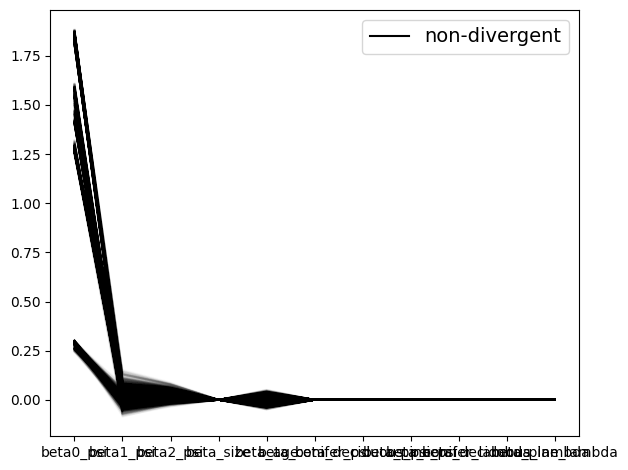

In [187]:

axes = az.plot_parallel(bundance_cond_occupancy_samples, var_names = vars_of_interest)
TEWAt1_parallel_plots = axes.figure
plt.tight_layout()
# TEWAt1_rank_plots.savefig(os.path.join(trial1_output_location_for_TEWA,'TEWA_t1_rank_plots.png'))

# Is a Poisson the best distribution?
This whole process, I've assumed that the mean and variance are equal. Here we'll check if a negative-binomial should be considered/.

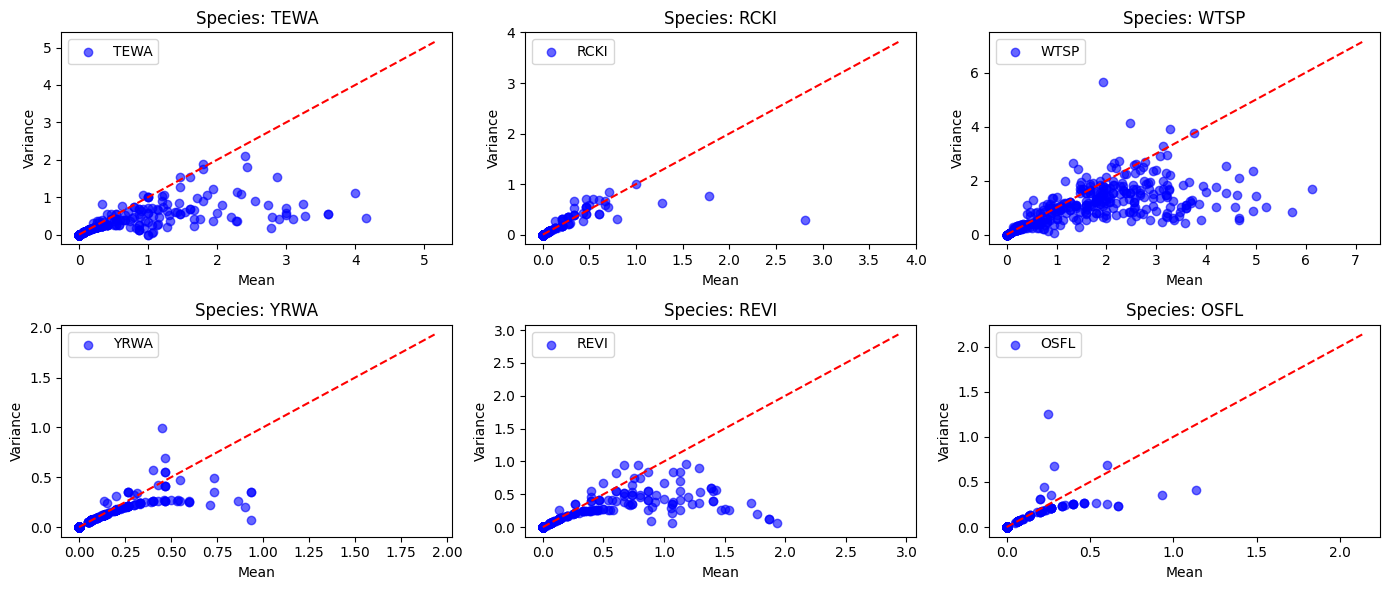

In [34]:
# Redoing the visualization using all sites, not just the overdispersed ones
species_columns = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Set up the figure and axes: 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 6))

# Flatten the 2D array of axes to iterate over it
axs = axs.flatten()

for ax, species in zip(axs, species_columns):
    grouped_species_data = counts.groupby(['location', 'recording_date_time'])[species].sum().reset_index()
    stats_data = grouped_species_data.groupby('location')[species].agg(['mean', 'var'])
    
    ax.scatter(stats_data['mean'], stats_data['var'], label=species, color='blue', alpha=0.6)
    ax.plot([0, stats_data['mean'].max() + 1], [0, stats_data['mean'].max() + 1], 'r--')  # Line where mean=variance
    ax.set_title(f"Species: {species}")
    ax.set_xlabel("Mean")
    ax.set_ylabel("Variance")
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'dispersion.png'))
